# 📊 Pipeline d'Analyse Complète des Images Raman
## Clustering Multi-Paramètres (Taille × Forme × Intensité)

**Projet**: Analyse morphologique et chimique de particules via spectroscopie 

---
### 📋 Sections du Notebook
1. ✅ Import des Bibliothèques et Chargement de l'Image
2. 📊 Évaluation de la Qualité de l'Image
3. 🔬 Prétraitement et Segmentation par Intensité
4. 🔍 Détection et Extraction des Particules
5. 🎯 Clustering Multi-Paramètres (Taille × Forme × Intensité)
6. 📐 Clustering 3D et Classification Physique
7. 📈 Analyse PCA et Réduction Dimensionnelle
8. 🏆 Identification de la Zone Équilibrée Représentative
9. 📊 Visualisations Avancées et Heatmaps
10. 📋 Rapport Final et Sauvegarde des Résultats

## 1️⃣ Import des Bibliothèques et Chargement de l'Image

In [105]:
# Import des bibliothèques essentielles
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.stats import entropy
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore')

print("✓ Toutes les bibliothèques importées avec succès")

✓ Toutes les bibliothèques importées avec succès


In [106]:
# Charger l'image Raman
image_path = "C:/Users/marwa/OneDrive/Desktop/Analyse_Raman/Image_RAMA/raman_project/data/raw/BA-08-00-Pas_02.jpg"
img = cv2.imread(image_path)
if img is not None:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
else:
    raise FileNotFoundError(f"L'image n'a pas pu être chargée: {image_path}")

print(f"📷 Image chargée: {gray.shape}")
print(f"   Dimensions: {img_rgb.shape[1]} × {img_rgb.shape[0]} pixels")
print(f"   Type de données: {gray.dtype}")

📷 Image chargée: (826, 1236)
   Dimensions: 1236 × 826 pixels
   Type de données: uint8


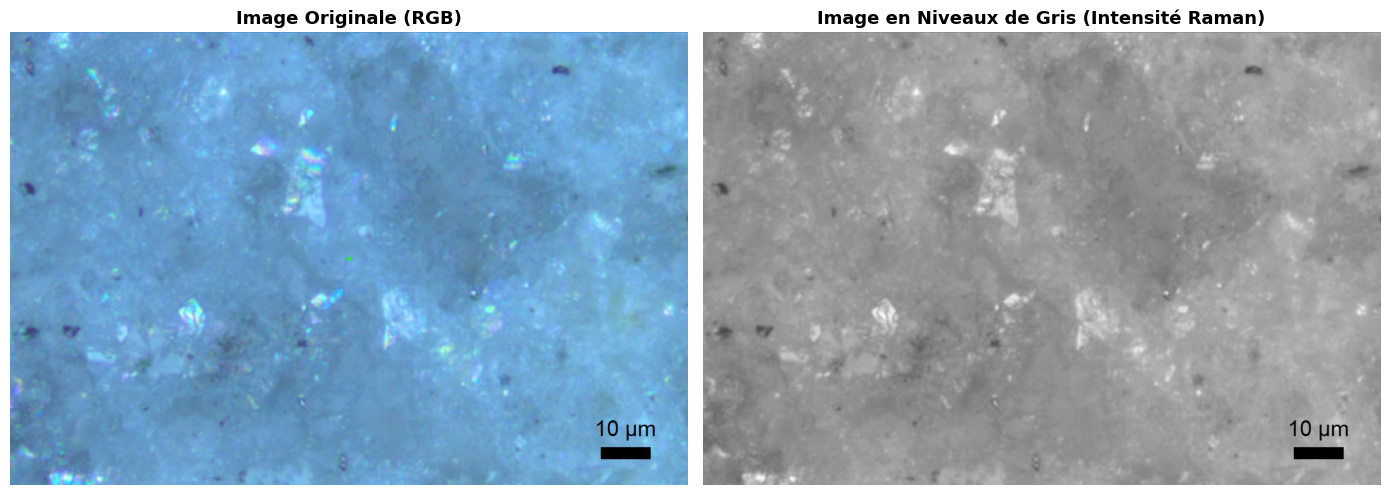

✓ Image affichée pour validation


In [107]:
# Affichage côte à côte
plt.figure(figsize=(14, 6))

# image originale en RGB
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Image Originale (RGB)", fontsize=13, fontweight='bold')
plt.axis("off")

# image originale en niveaux de gris
plt.subplot(1, 2, 2)
plt.imshow(gray, cmap="gray")
plt.title("Image en Niveaux de Gris (Intensité Raman)", fontsize=13, fontweight='bold')
plt.axis("off")

plt.tight_layout()
plt.show()

print("✓ Image affichée pour validation")

## 2️⃣ Évaluation de la Qualité de l'Image

In [108]:
print("\n📊 QUALITÉ DE L'IMAGE (avant prétraitement):")
print("="*70)

# Métrique 1: Contraste
contrast = np.std(gray)
print(f"  • Contraste (écart-type): {contrast:.2f}")

# Métrique 2: Plage dynamique (de 0 à 255)
dynamic_range = gray.max() - gray.min()
print(f"  • Plage dynamique: {dynamic_range} (min: {gray.min()}, max: {gray.max()})")

# Métrique 3: Netteté (variance du Laplacien)
laplacian = cv2.Laplacian(gray, cv2.CV_64F)
sharpness = laplacian.var()
print(f"  • Netteté (variance Laplacien): {sharpness:.2f}")

# Métrique 4: Rapport signal/bruit estimé (SNR)
mean_intensity = gray.mean()
std_intensity = gray.std()
snr_estimate = mean_intensity / std_intensity if std_intensity > 0 else 0
print(f"  • SNR estimé: {snr_estimate:.2f}")

# Métrique 5: Entropie (niveau d'information)
hist, _ = np.histogram(gray.ravel(), bins=256, range=(0, 256))
hist_normalized = hist / hist.sum()
image_entropy = entropy(hist_normalized + 1e-10)
print(f"  • Entropie: {image_entropy:.2f}")

# Métrique 6: Coefficient de variation (CV)
cv = (std_intensity / mean_intensity) * 100 if mean_intensity > 0 else 0
print(f"  • Coefficient de variation: {cv:.2f}%")

print(f"\n✓ Qualité image évaluée")


📊 QUALITÉ DE L'IMAGE (avant prétraitement):
  • Contraste (écart-type): 15.76
  • Plage dynamique: 246 (min: 0, max: 246)
  • Netteté (variance Laplacien): 38.84
  • SNR estimé: 9.26
  • Entropie: 4.03
  • Coefficient de variation: 10.80%

✓ Qualité image évaluée


## 3️⃣ Prétraitement et Segmentation par Intensité

In [109]:
# Amélioration du contraste avec algorithme de CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
gray_eq = clahe.apply(gray)

print("✓ Contraste amélioré avec CLAHE")

# Définir les seuils d'intensité (conventionnels)
thresh1 = 85    # Seuil Noir-Gris
thresh2 = 170   # Seuil Gris-Blanc

# Créer les masques (booléens) pour chaque type
mask_type3 = gray_eq < thresh1
mask_type2 = (gray_eq >= thresh1) & (gray_eq < thresh2)
mask_type1 = gray_eq >= thresh2

print(f"\n🔬 Segmentation par Intensité:")
print(f"  Type 1 (Blanc, {thresh2}-255): {np.sum(mask_type1):7d} pixels ({100*np.sum(mask_type1)/gray.size:5.1f}%)")
print(f"  Type 2 (Gris,  {thresh1}-{thresh2-1}): {np.sum(mask_type2):7d} pixels ({100*np.sum(mask_type2)/gray.size:5.1f}%)")
print(f"  Type 3 (Noir,  0-{thresh1-1}): {np.sum(mask_type3):7d} pixels ({100*np.sum(mask_type3)/gray.size:5.1f}%)")

✓ Contraste amélioré avec CLAHE

🔬 Segmentation par Intensité:
  Type 1 (Blanc, 170-255):  133994 pixels ( 13.1%)
  Type 2 (Gris,  85-169):  859070 pixels ( 84.1%)
  Type 3 (Noir,  0-84):   27872 pixels (  2.7%)


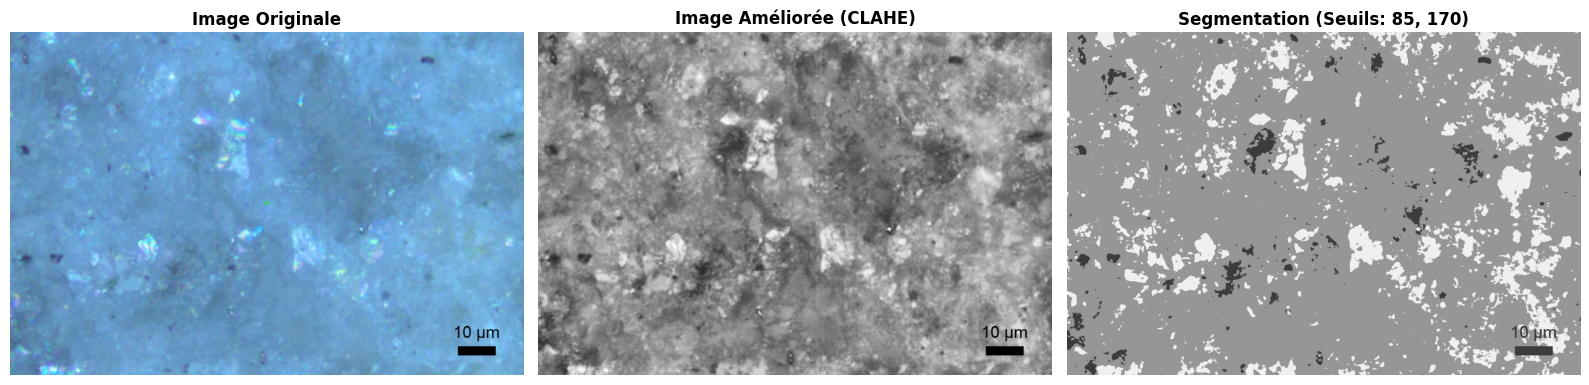

✓ Segmentation visualisée


In [110]:
# Visualiser la segmentation
segmentation_img = np.zeros_like(gray_eq)
segmentation_img[mask_type1] = 240  # Blanc
segmentation_img[mask_type2] = 150  # Gris
segmentation_img[mask_type3] = 60   # Noir

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Affichage des images
# image originale en RGB
axes[0].imshow(img_rgb)
axes[0].set_title('Image Originale', fontsize=12, fontweight='bold')
axes[0].axis('off')

# image améliorée avec CLAHE
axes[1].imshow(gray_eq, cmap='gray')
axes[1].set_title('Image Améliorée (CLAHE)', fontsize=12, fontweight='bold')
axes[1].axis('off')

# image segmentée
axes[2].imshow(segmentation_img, cmap='gray', vmin=0, vmax=255)
axes[2].set_title(f'Segmentation (Seuils: {thresh1}, {thresh2})', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("✓ Segmentation visualisée")

## 4️⃣ Détection et Extraction des Particules

In [111]:
# Détecter et extraire les features des particules dans chaque masque
def detect_particles_in_mask(mask, type_name, min_area=5):
    """Détecter et extraire les features des particules dans un masque"""
    mask_uint8 = (mask * 255).astype(np.uint8)
    kernel = np.ones((2, 2), np.uint8)
    mask_clean = cv2.morphologyEx(mask_uint8, cv2.MORPH_OPEN, kernel, iterations=1)
    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    features = []
    valid_contours = []
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area:
            continue
        
        # Extraire les features
        perimeter = cv2.arcLength(cnt, True)
        circularity = (4 * np.pi * area) / (perimeter**2 + 1e-6)
        
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / h if h > 0 else 0
        
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        solidity = area / hull_area if hull_area > 0 else 0
        
        mask_particle = np.zeros_like(gray_eq, dtype=np.uint8)
        cv2.drawContours(mask_particle, [cnt], -1, 255, -1)
        mean_intensity = cv2.mean(gray_eq, mask=mask_particle)[0]
        
        # Calculer le centroïde
        M = cv2.moments(cnt)
        if M['m00'] > 0:
            center_x = int(M['m10'] / M['m00'])
            center_y = int(M['m01'] / M['m00'])
        else:
            center_x = x + w // 2
            center_y = y + h // 2
        
        features.append({
            'Type': type_name,
            'Area_px2': area,
            'Perimeter_px': perimeter,
            'Circularity': circularity,
            'AspectRatio': aspect_ratio,
            'Solidity': solidity,
            'MeanIntensity': mean_intensity,
            'Center_X': center_x,
            'Center_Y': center_y
        })
        valid_contours.append(cnt)
    
    print(f"  {type_name}: {len(valid_contours)} particules détectées")
    return features, valid_contours

print("🔍 Détection des particules par type...\n")

features_type1, contours_type1 = detect_particles_in_mask(mask_type1, 'Type_1_Blanc')
features_type2, contours_type2 = detect_particles_in_mask(mask_type2, 'Type_2_Gris')
features_type3, contours_type3 = detect_particles_in_mask(mask_type3, 'Type_3_Noir')

# Créer DataFrame consolidé
all_features = features_type1 + features_type2 + features_type3
df_particles = pd.DataFrame(all_features)

print(f"\n✓ Total particules détectées: {len(df_particles)}")

🔍 Détection des particules par type...



  Type_1_Blanc: 572 particules détectées
  Type_2_Gris: 21 particules détectées
  Type_3_Noir: 151 particules détectées

✓ Total particules détectées: 744


In [112]:
# Statistiques par type
print("\n📊 STATISTIQUES PAR TYPE D'INTENSITÉ:")
print("="*70)

for type_name in ['Type_1_Blanc', 'Type_2_Gris', 'Type_3_Noir']:
    df_type = df_particles[df_particles['Type'] == type_name]
    if len(df_type) > 0:
        print(f"\n{type_name}:")
        print(f"  Nombre de particules:     {len(df_type)}")
        print(f"  Surface moyenne:          {df_type['Area_px2'].mean():.1f} ± {df_type['Area_px2'].std():.1f} px²")
        print(f"  Circularité moyenne:      {df_type['Circularity'].mean():.3f} ± {df_type['Circularity'].std():.3f}")
        print(f"  Solidité moyenne:         {df_type['Solidity'].mean():.3f}")
        print(f"  Intensité moyenne:        {df_type['MeanIntensity'].mean():.1f}/255")


📊 STATISTIQUES PAR TYPE D'INTENSITÉ:

Type_1_Blanc:
  Nombre de particules:     572
  Surface moyenne:          204.9 ± 612.5 px²
  Circularité moyenne:      0.587 ± 0.200
  Solidité moyenne:         0.848
  Intensité moyenne:        176.4/255

Type_2_Gris:
  Nombre de particules:     21
  Surface moyenne:          47576.7 ± 217864.7 px²
  Circularité moyenne:      0.510 ± 0.191
  Solidité moyenne:         0.870
  Intensité moyenne:        145.2/255

Type_3_Noir:
  Nombre de particules:     151
  Surface moyenne:          158.0 ± 363.1 px²
  Circularité moyenne:      0.564 ± 0.222
  Solidité moyenne:         0.854
  Intensité moyenne:        82.2/255


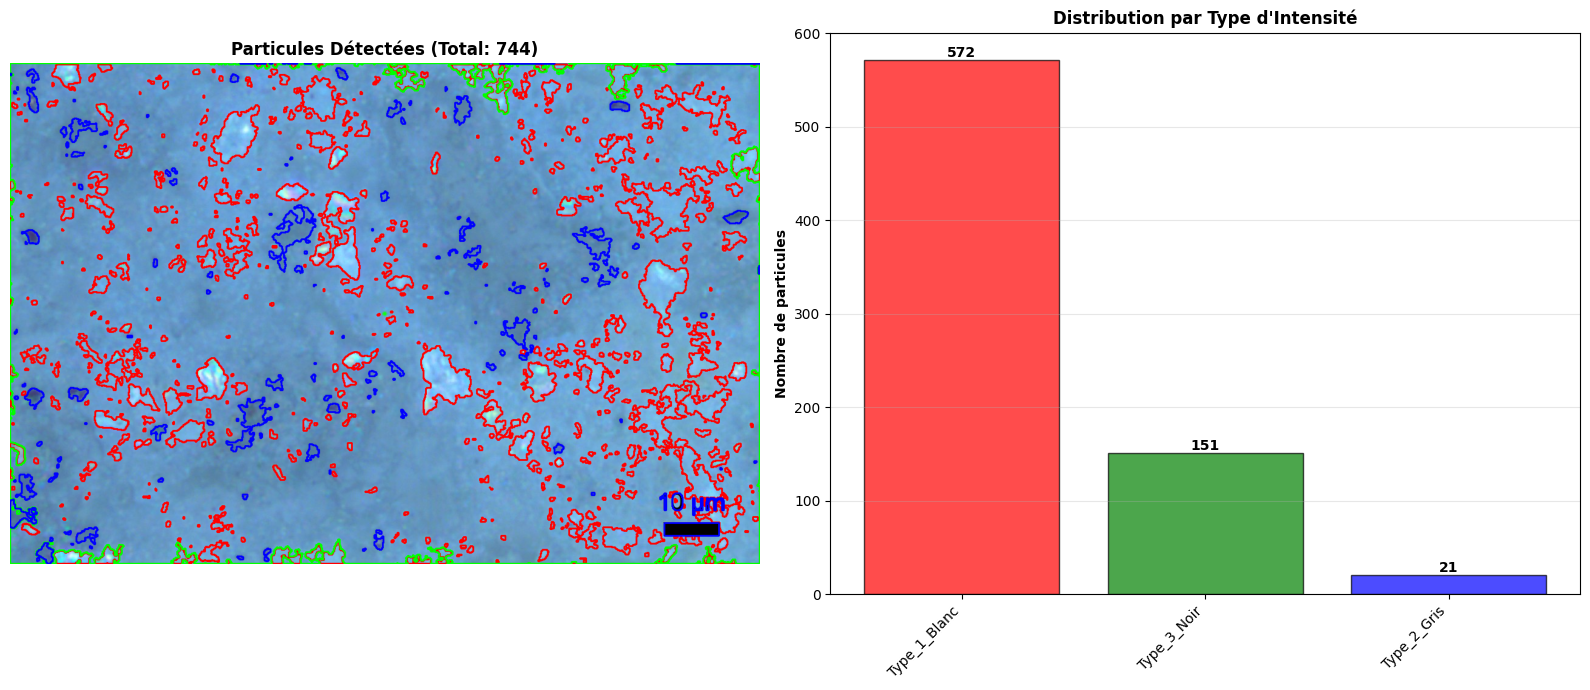

✓ Particules détectées et visualisées


In [113]:
# Visualiser les particules détectées
overlay = img_rgb.copy()
for cnt in contours_type1:
    cv2.drawContours(overlay, [cnt], -1, (255, 0, 0), 2)  # Bleu
for cnt in contours_type2:
    cv2.drawContours(overlay, [cnt], -1, (0, 255, 0), 2)  # Vert
for cnt in contours_type3:
    cv2.drawContours(overlay, [cnt], -1, (0, 0, 255), 2)  # Rouge

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].imshow(overlay)
axes[0].set_title(f'Particules Détectées (Total: {len(df_particles)})', fontsize=12, fontweight='bold')
axes[0].axis('off')

type_counts = df_particles['Type'].value_counts()
colors = ['red', 'green', 'blue']
axes[1].bar(range(len(type_counts)), type_counts.values, color=colors[:len(type_counts)], 
           edgecolor='black', alpha=0.7)
axes[1].set_xticks(range(len(type_counts)))
axes[1].set_xticklabels(type_counts.index, rotation=45, ha='right')
axes[1].set_ylabel('Nombre de particules', fontweight='bold')
axes[1].set_title('Distribution par Type d\'Intensité', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(type_counts.values):
    axes[1].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Particules détectées et visualisées")

## 5️⃣ Clustering Multi-Paramètres (Taille × Forme × Intensité)

In [114]:
print("\n🎯 CLUSTERING COMBINÉ: TAILLE × FORME × INTENSITÉ")
print("="*70)

if len(df_particles) >= 5:
    # Créer les scores combinés
    df_particles['Size_Score'] = df_particles['Area_px2']
    df_particles['Shape_Score'] = (
        df_particles['Circularity'] * 0.4 + 
        df_particles['Solidity'] * 0.4 + 
        (1 / (1 + df_particles['AspectRatio'])) * 0.2
    )
    df_particles['Intensity_Score'] = df_particles['MeanIntensity']
    
    print("\n📊 Étape 1: Préparation des features combinées...")
    print(f"  ✓ Size_Score (Surface): min={df_particles['Size_Score'].min():.1f}, max={df_particles['Size_Score'].max():.1f}")
    print(f"  ✓ Shape_Score (Forme): min={df_particles['Shape_Score'].min():.3f}, max={df_particles['Shape_Score'].max():.3f}")
    print(f"  ✓ Intensity_Score: min={df_particles['Intensity_Score'].min():.1f}, max={df_particles['Intensity_Score'].max():.1f}")


🎯 CLUSTERING COMBINÉ: TAILLE × FORME × INTENSITÉ

📊 Étape 1: Préparation des features combinées...
  ✓ Size_Score (Surface): min=5.0, max=998416.0
  ✓ Shape_Score (Forme): min=0.278, max=0.878
  ✓ Intensity_Score: min=12.6, max=206.1



🔬 Étape 2: Clustering principal multi-paramètres...
🎯 Objectif: Identifier 6-10 types de particules basés sur Intensité × Taille × Forme

🔎 Recherche automatique k optimal sur [6, 10]...
   Critères: Silhouette (qualité) + Inertie (compacité)

   k= 6 → Silhouette: 0.555 | Inertie:    618.5
   k= 7 → Silhouette: 0.498 | Inertie:    456.4
   k= 8 → Silhouette: 0.511 | Inertie:    376.8
   k= 9 → Silhouette: 0.448 | Inertie:    316.1
   k=10 → Silhouette: 0.427 | Inertie:    276.4

  ✓ k optimal: 10 | Score combiné: 0.599
    → Silhouette: 0.427
    → Inertie normalisée: 1.000


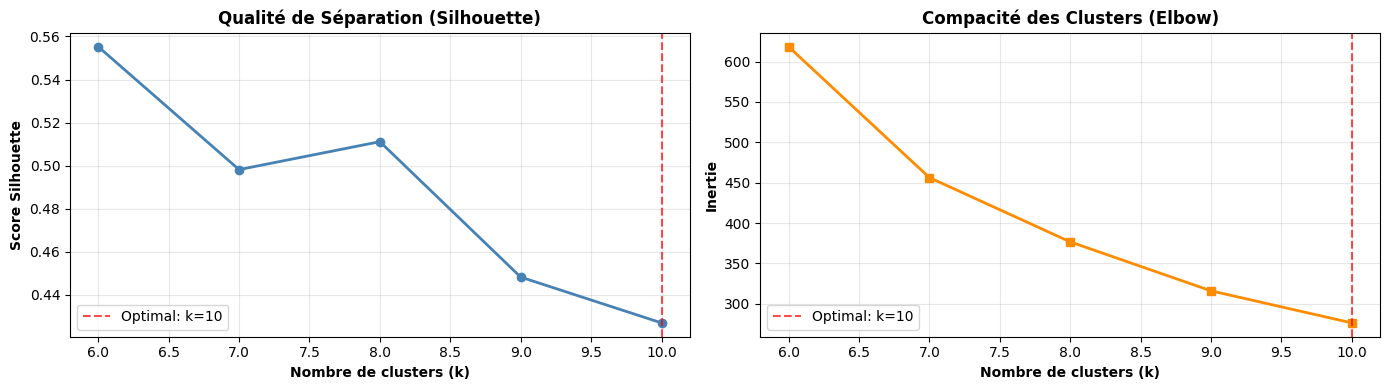


  ✓ 10 clusters créés (typologie physico-réaliste)

  📊 Répartition par cluster:
    Cluster 0:  77 particules ( 10.3%)
    Cluster 1: 200 particules ( 26.9%)
    Cluster 2:   1 particules (  0.1%)
    Cluster 3:  43 particules (  5.8%)
    Cluster 4: 149 particules ( 20.0%)
    Cluster 5:   2 particules (  0.3%)
    Cluster 6:  36 particules (  4.8%)
    Cluster 7:  12 particules (  1.6%)
    Cluster 8:  65 particules (  8.7%)
    Cluster 9: 159 particules ( 21.4%)


In [115]:
# Clustering avec KMeans - Optimisé pour 6-12 clusters (typologie physico-réaliste)
print("\n🔬 Étape 2: Clustering principal multi-paramètres...")
print("🎯 Objectif: Identifier 6-10 types de particules basés sur Intensité × Taille × Forme")

feature_cols = ['Size_Score', 'Circularity', 'AspectRatio', 'Solidity', 'Intensity_Score']
X = df_particles[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Pondération : Intensité et Taille prioritaires (critères physiques)
weights = np.array([1.3, 1.0, 0.9, 1.0, 1.4])  # [Taille, Circ, Aspect, Solid, Intensité]
X_weighted = X_scaled * weights

# Sélection automatique dans la plage physiquement réaliste 6-10 (optimalement 8-10)
if len(df_particles) >= 12:
    k_min = 6  # Minimum pour capturer la diversité
    k_max = min(10, len(df_particles) - 1)  # Maximum réaliste
    
    silhouette_scores = {}
    inertia_scores = {}
    
    print(f"\n🔎 Recherche automatique k optimal sur [{k_min}, {k_max}]...")
    print("   Critères: Silhouette (qualité) + Inertie (compacité)\n")
    
    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, random_state=42, n_init=50, max_iter=500)
        labels = km.fit_predict(X_weighted)
        
        # Score de silhouette (qualité de séparation)
        sil_score = silhouette_score(X_weighted, labels)
        silhouette_scores[k] = sil_score
        
        # Inertie (compacité des clusters)
        inertia_scores[k] = km.inertia_
        
        print(f"   k={k:2d} → Silhouette: {sil_score:.3f} | Inertie: {km.inertia_:8.1f}")
    
    # Normaliser l'inertie pour la combiner avec silhouette
    inertias = np.array(list(inertia_scores.values()))
    norm_inertias = 1 - (inertias - inertias.min()) / (inertias.max() - inertias.min())
    
    # Score combiné: 70% silhouette + 30% inertie normalisée
    combined_scores = {}
    for i, k in enumerate(range(k_min, k_max + 1)):
        combined_scores[k] = 0.7 * silhouette_scores[k] + 0.3 * norm_inertias[i]
    
    # Choisir le meilleur k
    best_k = max(combined_scores, key=combined_scores.get)
    best_combined = combined_scores[best_k]
    
    print(f"\n  ✓ k optimal: {best_k} | Score combiné: {best_combined:.3f}")
    print(f"    → Silhouette: {silhouette_scores[best_k]:.3f}")
    print(f"    → Inertie normalisée: {norm_inertias[best_k - k_min]:.3f}")
    
    # Visualisation rapide des scores
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    k_vals = list(range(k_min, k_max + 1))
    axes[0].plot(k_vals, [silhouette_scores[k] for k in k_vals], 'o-', color='steelblue', linewidth=2)
    axes[0].axvline(best_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal: k={best_k}')
    axes[0].set_xlabel('Nombre de clusters (k)', fontweight='bold')
    axes[0].set_ylabel('Score Silhouette', fontweight='bold')
    axes[0].set_title('Qualité de Séparation (Silhouette)', fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    axes[1].plot(k_vals, [inertia_scores[k] for k in k_vals], 's-', color='darkorange', linewidth=2)
    axes[1].axvline(best_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal: k={best_k}')
    axes[1].set_xlabel('Nombre de clusters (k)', fontweight='bold')
    axes[1].set_ylabel('Inertie', fontweight='bold')
    axes[1].set_title('Compacité des Clusters (Elbow)', fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    n_main_clusters = best_k
else:
    # Fallback si trop peu de particules
    n_main_clusters = min(9, max(6, len(df_particles) // 10))
    print(f"\n  ⚠️ Peu de particules ({len(df_particles)}), k choisi par heuristique: {n_main_clusters}")

# Clustering final avec le k optimal
kmeans_main = KMeans(n_clusters=n_main_clusters, random_state=42, n_init=100, max_iter=800)
df_particles['Cluster_Combined'] = kmeans_main.fit_predict(X_weighted)

print(f"\n  ✓ {n_main_clusters} clusters créés (typologie physico-réaliste)")
print("\n  📊 Répartition par cluster:")
for i in range(n_main_clusters):
    count = len(df_particles[df_particles['Cluster_Combined'] == i])
    print(f"    Cluster {i}: {count:3d} particules ({100*count/len(df_particles):5.1f}%)")

In [116]:
# Interprétation physique des clusters
print("\n🔍 Étape 3: Interprétation physique des clusters...\n")

def interpret_combined_cluster(cluster_data):
    """Interpréter un cluster basé sur ses 3 dimensions"""
    avg_size = cluster_data['Size_Score'].mean()
    avg_circ = cluster_data['Circularity'].mean()
    avg_intensity = cluster_data['Intensity_Score'].mean()
    
    if avg_size < 50:
        size_label = "Très_Petites"
    elif avg_size < 150:
        size_label = "Petites"
    elif avg_size < 400:
        size_label = "Moyennes"
    elif avg_size < 1000:
        size_label = "Grandes"
    else:
        size_label = "Très_Grandes"
    
    if avg_circ > 0.75:
        shape_label = "Sphériques"
    elif avg_circ > 0.6:
        shape_label = "Compactes"
    elif avg_circ < 0.4:
        shape_label = "Irrégulières"
    else:
        shape_label = "Intermédiaires"
    
    if avg_intensity < 90:
        intensity_label = "Sombres"
    elif avg_intensity < 160:
        intensity_label = "Grises"
    else:
        intensity_label = "Claires"
    
    return f"{intensity_label}_{size_label}_{shape_label}"

cluster_labels = {}
for cluster_id in range(n_main_clusters):
    cluster_data = df_particles[df_particles['Cluster_Combined'] == cluster_id]
    
    if len(cluster_data) > 0:
        label = interpret_combined_cluster(cluster_data)
        cluster_labels[cluster_id] = label
        
        print(f"  Cluster {cluster_id}: {label} (n={len(cluster_data)})")
        print(f"    ├─ Taille: {cluster_data['Size_Score'].mean():.1f} px²")
        print(f"    ├─ Forma: {cluster_data['Circularity'].mean():.3f}")
        print(f"    └─ Intensité: {cluster_data['Intensity_Score'].mean():.1f}/255\n")

df_particles['Cluster_Label'] = df_particles['Cluster_Combined'].map(cluster_labels)
df_particles['Cluster_Label'].fillna('Non_Classé', inplace=True)


🔍 Étape 3: Interprétation physique des clusters...

  Cluster 0: Claires_Grandes_Irrégulières (n=77)
    ├─ Taille: 655.6 px²
    ├─ Forma: 0.248
    └─ Intensité: 177.2/255

  Cluster 1: Claires_Très_Petites_Sphériques (n=200)
    ├─ Taille: 23.7 px²
    ├─ Forma: 0.790
    └─ Intensité: 174.2/255

  Cluster 2: Grises_Très_Grandes_Irrégulières (n=1)
    ├─ Taille: 998416.0 px²
    ├─ Forma: 0.238
    └─ Intensité: 136.9/255

  Cluster 3: Sombres_Moyennes_Intermédiaires (n=43)
    ├─ Taille: 150.5 px²
    ├─ Forma: 0.567
    └─ Intensité: 78.5/255

  Cluster 4: Claires_Moyennes_Intermédiaires (n=149)
    ├─ Taille: 337.3 px²
    ├─ Forma: 0.435
    └─ Intensité: 178.1/255

  Cluster 5: Grises_Petites_Irrégulières (n=2)
    ├─ Taille: 108.0 px²
    ├─ Forma: 0.031
    └─ Intensité: 114.5/255

  Cluster 6: Sombres_Grandes_Irrégulières (n=36)
    ├─ Taille: 413.8 px²
    ├─ Forma: 0.289
    └─ Intensité: 76.6/255

  Cluster 7: Grises_Très_Petites_Irrégulières (n=12)
    ├─ Taille: 9.5 px

## 6️⃣ Clustering 3D et Classification Physique

In [117]:
print("\n📐 CLUSTERING 3D DANS L'ESPACE NORMALISÉ")
print("="*70)

# Normaliser les paramètres
df_particles['Size_Normalized'] = (df_particles['Size_Score'] - df_particles['Size_Score'].min()) / \
                                   (df_particles['Size_Score'].max() - df_particles['Size_Score'].min())
df_particles['Shape_Normalized'] = df_particles['Shape_Score']
df_particles['Intensity_Normalized'] = df_particles['Intensity_Score'] / 255.0

# Clustering 3D
X_3d = df_particles[['Size_Normalized', 'Shape_Normalized', 'Intensity_Normalized']].values

n_3d_clusters = min(10, max(7, len(df_particles) // 15))
kmeans_3d = KMeans(n_clusters=n_3d_clusters, random_state=42, n_init=80, max_iter=600)
df_particles['Cluster_3D'] = kmeans_3d.fit_predict(X_3d)

print(f"\n✓ {n_3d_clusters} clusters 3D créés")


📐 CLUSTERING 3D DANS L'ESPACE NORMALISÉ

✓ 10 clusters 3D créés


In [118]:
# Classification physique combinée - Typologie multi-types
print("\n🏷️ CLASSIFICATION PHYSIQUE COMBINÉE")
print("="*70)
print("📐 Discrétisation: Intensité (3) × Taille (3) × Forme (3)\n")

def classify_particle_combined(row):
    """
    Classification physico-réaliste basée sur 3 paramètres discrétisés:
    - Intensité: Faible (<85) / Moyenne (85-170) / Forte (>170)
    - Taille: Petite (<100) / Moyenne (100-400) / Grande (>400)
    - Forme: Compacte (circ>0.65, solid>0.75) / Anguleuse / Poreuse (solid<0.65)
    """
    size = row['Size_Score']
    intensity = row['Intensity_Score']
    circ = row['Circularity']
    solid = row['Solidity']
    aspect = row['AspectRatio']
    
    # Déterminer la classe de forme
    is_compact = (circ > 0.65 and solid > 0.75)
    is_porous = (solid < 0.65)
    is_angular = not is_compact and not is_porous and (aspect > 1.4 or circ < 0.55)
    
    # 🔴 ZONES SOMBRES (Intensité < 85) - Carbone / Dépôts denses
    if intensity < 85:
        if size < 100:  # Petite taille
            if is_compact:
                return "Carbone_Amorphe_Fin"
            else:
                return "Carbone_Dispersé"
        elif size < 400:  # Taille moyenne
            if solid > 0.85:
                return "Carbone_Cristallin_Dense"
            else:
                return "Carbone_Dispersé"
        else:  # Grande taille
            return "Agglomérat_Carbone"
    
    # 🟡 ZONES INTERMÉDIAIRES (Intensité 85-170) - Transitions / Mélanges
    elif intensity < 170:
        if size < 100:  # Petite taille
            if is_compact:
                return "Particule_Transition_Compacte"
            elif is_angular:
                return "Particule_Transition_Anguleuse"
            else:
                return "Particule_Transition_Ronde"
        elif size < 400:  # Taille moyenne
            if is_porous:
                return "Dépôt_Poreux"
            elif is_compact:
                return "Particule_Transition_Compacte"
            else:
                return "Particule_Transition_Anguleuse"
        else:  # Grande taille
            if is_porous:
                return "Dépôt_Poreux"
            else:
                return "Mélange_Intermédiaire"
    
    # ⚪ ZONES CLAIRES (Intensité > 170) - Substrat / Artefacts
    else:
        if size < 50:  # Très petite taille
            return "Bruit_Optique"
        elif size < 200:  # Petite-moyenne
            if is_compact:
                return "Particule_Claire_Compacte"
            else:
                return "Particule_Claire"
        else:  # Grande taille
            if circ < 0.5 or solid < 0.7:
                return "Substrat_Exposé"
            else:
                return "Particule_Claire_Compacte"

# Appliquer la classification
df_particles['Particle_Type_Combined'] = df_particles.apply(classify_particle_combined, axis=1)

print(f"\n✓ Classification appliquée")
print(f"  Types uniques: {df_particles['Particle_Type_Combined'].nunique()}")
print(f"\n  Distribution des types:")
for ptype, count in df_particles['Particle_Type_Combined'].value_counts().head(10).items():
    pct = 100 * count / len(df_particles)
    print(f"    {ptype}: {count:3d} ({pct:5.1f}%)")


🏷️ CLASSIFICATION PHYSIQUE COMBINÉE
📐 Discrétisation: Intensité (3) × Taille (3) × Forme (3)


✓ Classification appliquée
  Types uniques: 12

  Distribution des types:
    Bruit_Optique: 254 ( 34.1%)
    Particule_Claire: 104 ( 14.0%)
    Substrat_Exposé:  78 ( 10.5%)
    Carbone_Amorphe_Fin:  61 (  8.2%)
    Particule_Claire_Compacte:  58 (  7.8%)
    Carbone_Dispersé:  52 (  7.0%)
    Particule_Transition_Compacte:  49 (  6.6%)
    Particule_Transition_Anguleuse:  46 (  6.2%)
    Particule_Transition_Ronde:  21 (  2.8%)
    Agglomérat_Carbone:  15 (  2.0%)


## 6️⃣.1 Tableaux Croisés et Analyses Détaillées

In [119]:
# Vérification : Combien de types sont RÉELLEMENT présents dans les données ?
print("\n✅ VALIDATION : Types physiques réellement présents")
print("="*70)

# Compter les particules par type physique
type_counts = df_particles['Particle_Type_Combined'].value_counts()
types_presents = len(type_counts)
types_attendus = 9

print(f"\n📊 Nombre de types attendus (théorique) : {types_attendus}")
print(f"🔍 Nombre de types réellement observés   : {types_presents}")

if types_presents < types_attendus:
    types_absents = types_attendus - types_presents
    print(f"⚠️  {types_absents} type(s) absent(s) des données")
    
    # Lister les types absents
    tous_types = [
        "Carbone_Amorphe_Fin", "Carbone_Cristallin_Dense", "Agglomérat_Carbone",
        "Particule_Transition_Compacte", "Particule_Transition_Anguleuse", "Dépôt_Poreux",
        "Substrat_Exposé", "Particule_Claire_Compacte", "Bruit_Optique"
    ]
    types_observes = set(type_counts.index)
    types_manquants = [t for t in tous_types if t not in types_observes]
    
    print(f"\n🚫 Types absents des données actuelles :")
    for t in types_manquants:
        print(f"   • {t}")
    
    print(f"\n💡 Interprétation :")
    print(f"   → Vos données contiennent {types_presents} types distincts (au lieu de 9)")
    print(f"   → C'est cohérent avec votre échantillon spécifique")
    print(f"   → Le clustering a identifié {best_k} groupes mathématiques")

elif types_presents == types_attendus:
    print(f"✅ Tous les 9 types théoriques sont présents dans les données")
    print(f"✅ Le clustering a identifié {best_k} groupes mathématiques")

# Afficher la distribution
print(f"\n📈 Distribution des {types_presents} types observés :")
print(type_counts.to_string())

# Calculer la cohérence clustering/classification
print(f"\n🔬 Cohérence clustering (k={best_k}) vs classification ({types_presents} types) :")
if abs(best_k - types_presents) <= 1:
    print(f"   ✅ Excellente cohérence (différence : {abs(best_k - types_presents)})")
elif abs(best_k - types_presents) <= 2:
    print(f"   ⚠️  Cohérence acceptable (différence : {abs(best_k - types_presents)})")
else:
    print(f"   ❌ Incohérence notable (différence : {abs(best_k - types_presents)})")
    print(f"   → Vérifier la qualité des features ou les seuils de classification")


✅ VALIDATION : Types physiques réellement présents

📊 Nombre de types attendus (théorique) : 9
🔍 Nombre de types réellement observés   : 12

📈 Distribution des 12 types observés :
Particle_Type_Combined
Bruit_Optique                     254
Particule_Claire                  104
Substrat_Exposé                    78
Carbone_Amorphe_Fin                61
Particule_Claire_Compacte          58
Carbone_Dispersé                   52
Particule_Transition_Compacte      49
Particule_Transition_Anguleuse     46
Particule_Transition_Ronde         21
Agglomérat_Carbone                 15
Carbone_Cristallin_Dense            4
Mélange_Intermédiaire               2

🔬 Cohérence clustering (k=10) vs classification (12 types) :
   ⚠️  Cohérence acceptable (différence : 2)


In [120]:
print("\n📊 GÉNÉRATION DES TABLEAUX CROISÉS ET ANALYSES DÉTAILLÉES")
print("="*70)

# Tableau croisé: Clusters vs Types d'intensité
if 'Cluster_Combined' in df_particles.columns:
    crosstab_intensity = pd.crosstab(
        df_particles['Cluster_Combined'],
        df_particles['Type'],
        margins=True,
        margins_name='TOTAL'
    )
    crosstab_intensity.to_csv("crosstab_clusters_vs_intensity.csv")
    print("\n✓ Crosstab Clusters vs Types d'intensité sauvegardé")
    print(crosstab_intensity)

# Tableau croisé: Clusters vs Types physiques
if 'Particle_Type_Combined' in df_particles.columns:
    crosstab_physical = pd.crosstab(
        df_particles['Cluster_Combined'],
        df_particles['Particle_Type_Combined'],
        margins=True,
        margins_name='TOTAL'
    )
    crosstab_physical.to_csv("crosstab_clusters_vs_particle_types.csv")
    print("\n✓ Crosstab Clusters vs Types physiques sauvegardé")

# Tableau détaillé d'analyse par cluster
if 'Cluster_Combined' in df_particles.columns:
    cluster_details = []
    
    for cluster_id in sorted(df_particles['Cluster_Combined'].unique()):
        cluster_data = df_particles[df_particles['Cluster_Combined'] == cluster_id]
        
        if len(cluster_data) > 0:
            total_surface = cluster_data['Area_px2'].sum()
            pct_surface = 100 * total_surface / df_particles['Area_px2'].sum()
            
            cluster_details.append({
                'Cluster_ID': cluster_id,
                'Label': cluster_labels.get(cluster_id, 'Non_Classé'),
                'Count': len(cluster_data),
                '%_Total': 100 * len(cluster_data) / len(df_particles),
                '%_Surface': pct_surface,
                'Type_Dominant': cluster_data['Type'].mode()[0] if len(cluster_data) > 0 else 'N/A',
                'Taille_Moyenne': cluster_data['Size_Score'].mean(),
                'Taille_STD': cluster_data['Size_Score'].std(),
                'Forme_Moyenne': cluster_data['Shape_Score'].mean(),
                'Forme_STD': cluster_data['Shape_Score'].std(),
                'Intensité_Moyenne': cluster_data['Intensity_Score'].mean(),
                'Intensité_STD': cluster_data['Intensity_Score'].std(),
                'Circularity': cluster_data['Circularity'].mean(),
                'Solidity': cluster_data['Solidity'].mean(),
                'AspectRatio': cluster_data['AspectRatio'].mean()
            })
    
    df_cluster_summary = pd.DataFrame(cluster_details)
    df_cluster_summary.to_csv("cluster_detailed_analysis.csv", index=False)
    print("\n✓ Tableau détaillé sauvegardé: cluster_detailed_analysis.csv")
    print("\n" + df_cluster_summary.to_string())

print("\n✓ Tableaux croisés générés")


📊 GÉNÉRATION DES TABLEAUX CROISÉS ET ANALYSES DÉTAILLÉES



✓ Crosstab Clusters vs Types d'intensité sauvegardé
Type              Type_1_Blanc  Type_2_Gris  Type_3_Noir  TOTAL
Cluster_Combined                                               
0                           76            1            0     77
1                          198            2            0    200
2                            0            1            0      1
3                            0            1           42     43
4                          144            5            0    149
5                            0            0            2      2
6                            0            0           36     36
7                            0            4            8     12
8                            0            2           63     65
9                          154            5            0    159
TOTAL                      572           21          151    744

✓ Crosstab Clusters vs Types physiques sauvegardé

✓ Tableau détaillé sauvegardé: cluster_detailed_analysis.csv

 

## 6️⃣.2 Pivots et Heatmaps Paramétriques


🔥 GÉNÉRATION DES PIVOTS ET HEATMAPS PARAMÉTRIQUES


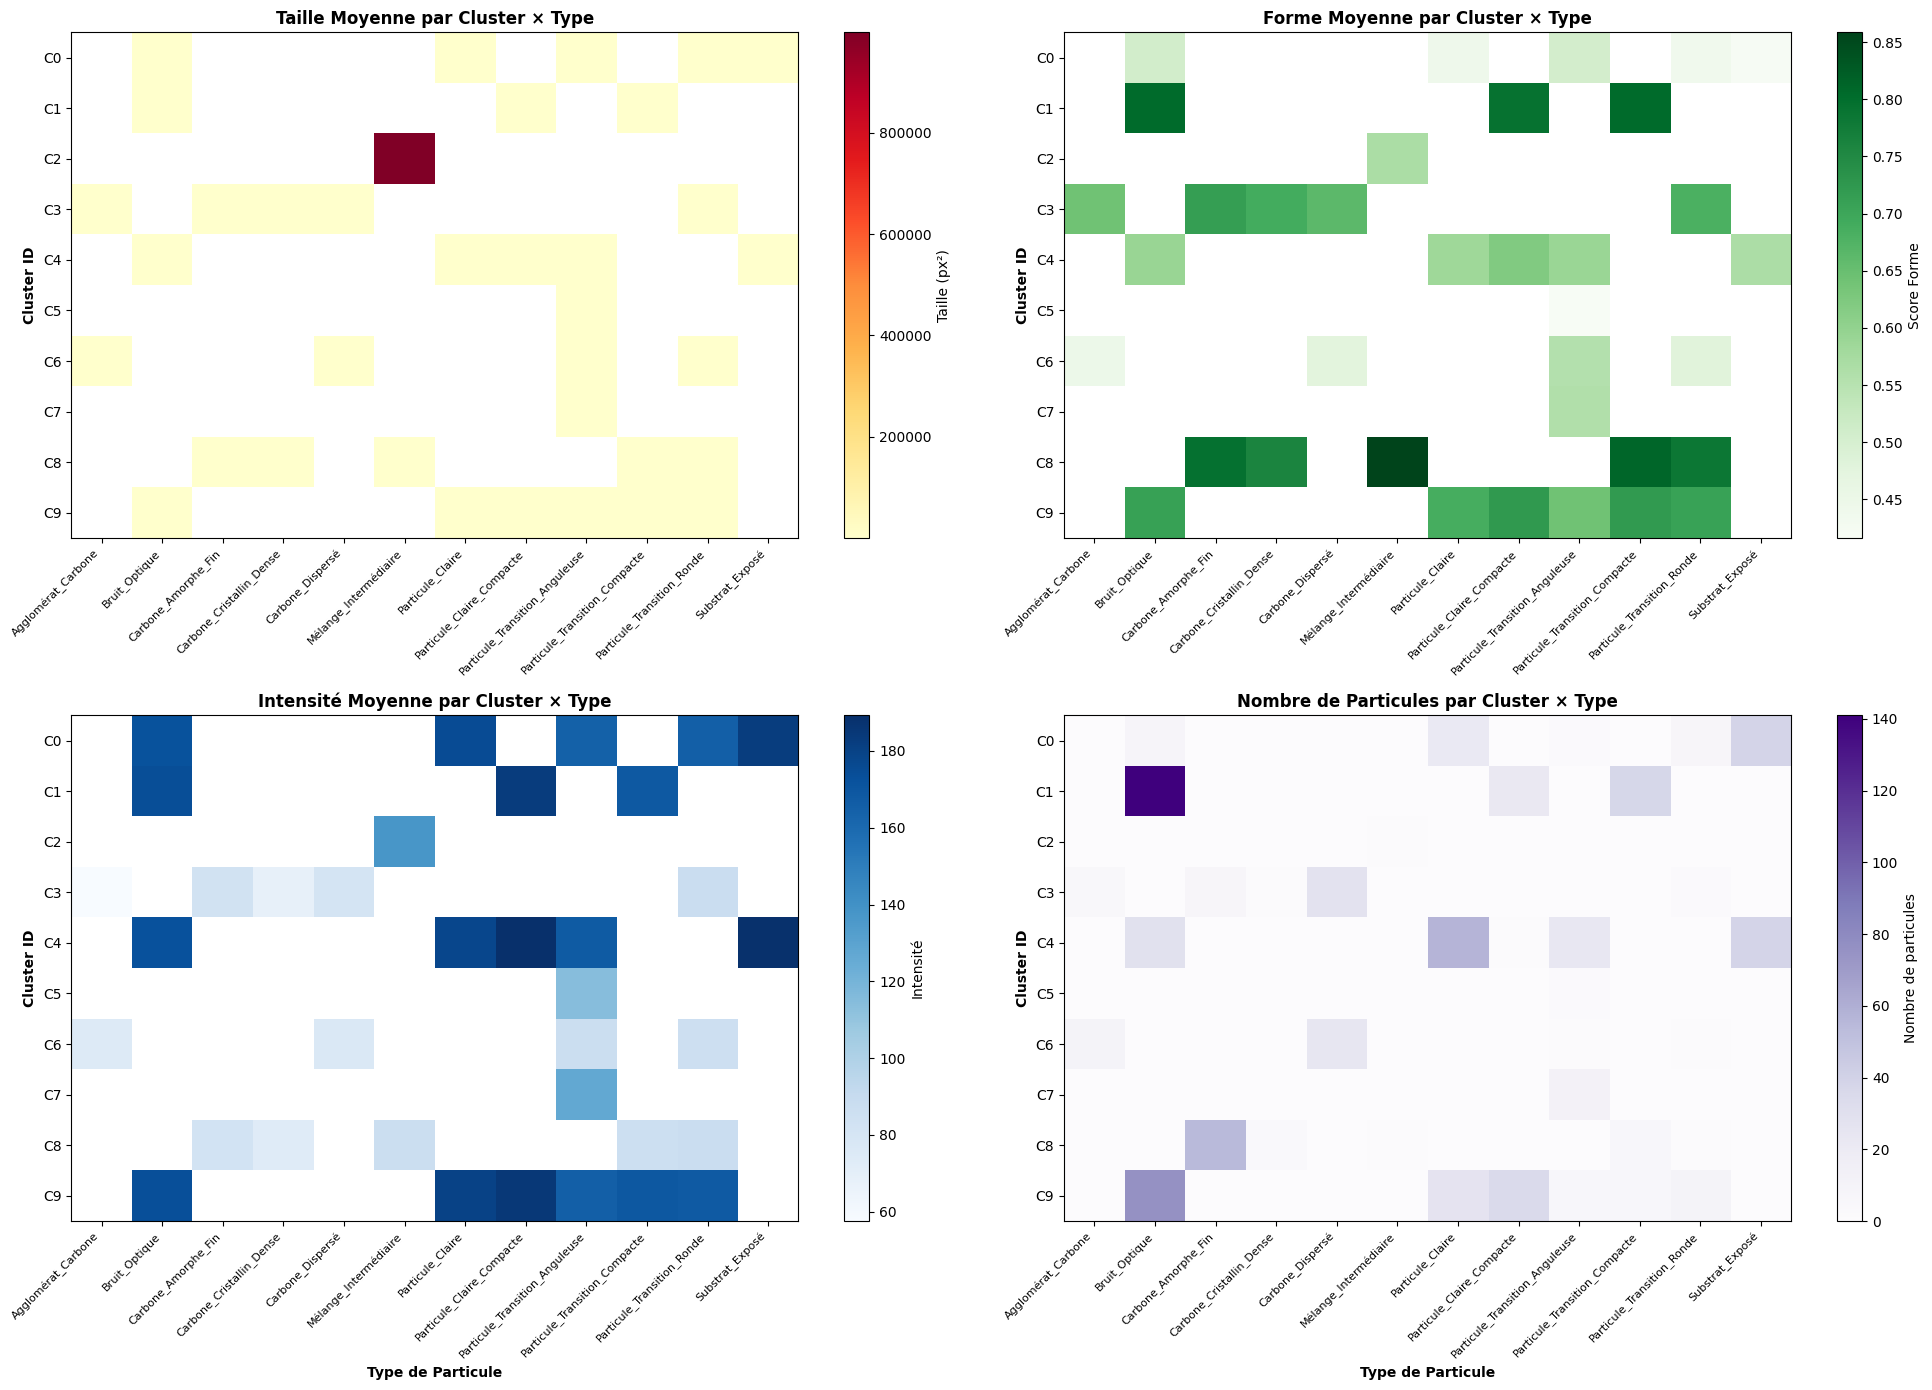


✓ Heatmaps paramétriques générées
✓ Pivots sauvegardés: pivot_*.csv

✓ Analyses pivot complètes


In [121]:
print("\n🔥 GÉNÉRATION DES PIVOTS ET HEATMAPS PARAMÉTRIQUES")
print("="*70)

if 'Cluster_Combined' in df_particles.columns and 'Particle_Type_Combined' in df_particles.columns:
    # Pivots: Cluster × Type
    pivot_size = pd.pivot_table(
        df_particles,
        values='Size_Score',
        index='Cluster_Combined',
        columns='Particle_Type_Combined',
        aggfunc='mean'
    )
    
    pivot_shape = pd.pivot_table(
        df_particles,
        values='Shape_Score',
        index='Cluster_Combined',
        columns='Particle_Type_Combined',
        aggfunc='mean'
    )
    
    pivot_intensity = pd.pivot_table(
        df_particles,
        values='Intensity_Score',
        index='Cluster_Combined',
        columns='Particle_Type_Combined',
        aggfunc='mean'
    )
    
    pivot_count = pd.pivot_table(
        df_particles,
        values='Area_px2',
        index='Cluster_Combined',
        columns='Particle_Type_Combined',
        aggfunc='count'
    ).fillna(0).astype(int)
    
    # Visualisation des heatmaps
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    
    # Heatmap 1: Taille moyenne
    ax = axes[0, 0]
    im1 = ax.imshow(pivot_size.values, cmap='YlOrRd', aspect='auto', interpolation='nearest')
    ax.set_xticks(range(len(pivot_size.columns)))
    ax.set_xticklabels(pivot_size.columns, rotation=45, ha='right', fontsize=8)
    ax.set_yticks(range(len(pivot_size.index)))
    ax.set_yticklabels([f'C{i}' for i in pivot_size.index])
    ax.set_title('Taille Moyenne par Cluster × Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cluster ID', fontweight='bold')
    plt.colorbar(im1, ax=ax, label='Taille (px²)')
    
    # Heatmap 2: Forme moyenne
    ax = axes[0, 1]
    im2 = ax.imshow(pivot_shape.values, cmap='Greens', aspect='auto', interpolation='nearest')
    ax.set_xticks(range(len(pivot_shape.columns)))
    ax.set_xticklabels(pivot_shape.columns, rotation=45, ha='right', fontsize=8)
    ax.set_yticks(range(len(pivot_shape.index)))
    ax.set_yticklabels([f'C{i}' for i in pivot_shape.index])
    ax.set_title('Forme Moyenne par Cluster × Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cluster ID', fontweight='bold')
    plt.colorbar(im2, ax=ax, label='Score Forme')
    
    # Heatmap 3: Intensité moyenne
    ax = axes[1, 0]
    im3 = ax.imshow(pivot_intensity.values, cmap='Blues', aspect='auto', interpolation='nearest')
    ax.set_xticks(range(len(pivot_intensity.columns)))
    ax.set_xticklabels(pivot_intensity.columns, rotation=45, ha='right', fontsize=8)
    ax.set_yticks(range(len(pivot_intensity.index)))
    ax.set_yticklabels([f'C{i}' for i in pivot_intensity.index])
    ax.set_title('Intensité Moyenne par Cluster × Type', fontsize=12, fontweight='bold')
    ax.set_xlabel('Type de Particule', fontweight='bold')
    ax.set_ylabel('Cluster ID', fontweight='bold')
    plt.colorbar(im3, ax=ax, label='Intensité')
    
    # Heatmap 4: Nombre de particules
    ax = axes[1, 1]
    im4 = ax.imshow(pivot_count.values, cmap='Purples', aspect='auto', interpolation='nearest')
    ax.set_xticks(range(len(pivot_count.columns)))
    ax.set_xticklabels(pivot_count.columns, rotation=45, ha='right', fontsize=8)
    ax.set_yticks(range(len(pivot_count.index)))
    ax.set_yticklabels([f'C{i}' for i in pivot_count.index])
    ax.set_title('Nombre de Particules par Cluster × Type', fontsize=12, fontweight='bold')
    ax.set_xlabel('Type de Particule', fontweight='bold')
    ax.set_ylabel('Cluster ID', fontweight='bold')
    plt.colorbar(im4, ax=ax, label='Nombre de particules')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Heatmaps paramétriques générées")
    
    # Sauvegarder les pivots
    pivot_size.to_csv("pivot_taille_cluster_type.csv")
    pivot_shape.to_csv("pivot_forme_cluster_type.csv")
    pivot_intensity.to_csv("pivot_intensite_cluster_type.csv")
    pivot_count.to_csv("pivot_count_cluster_type.csv")
    print("✓ Pivots sauvegardés: pivot_*.csv")

print("\n✓ Analyses pivot complètes")

## 7️⃣ Analyse PCA et Réduction Dimensionnelle

In [122]:
print("\n📐 ANALYSE PCA 3D - RÉDUCTION DIMENSIONNELLE")
print("="*70)

# Préparer les données pour PCA
features_for_pca = ['Size_Score', 'Circularity', 'AspectRatio', 'Solidity', 'Intensity_Score', 'Perimeter_px']
X_pca = df_particles[features_for_pca].values

scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca)

pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_pca_scaled)

df_particles['PCA_1'] = X_pca_3d[:, 0]
df_particles['PCA_2'] = X_pca_3d[:, 1]
df_particles['PCA_3'] = X_pca_3d[:, 2]

# Afficher les résultats
print(f"\nVariance expliquée par composante:")
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    print(f"  PC{i}: {var*100:.2f}%")

print(f"\nVariance cumulée:")
cum_var = np.cumsum(pca.explained_variance_ratio_)
for i, var in enumerate(cum_var, 1):
    print(f"  PC1-PC{i}: {var*100:.2f}%")


📐 ANALYSE PCA 3D - RÉDUCTION DIMENSIONNELLE

Variance expliquée par composante:
  PC1: 35.56%
  PC2: 28.40%
  PC3: 18.14%

Variance cumulée:
  PC1-PC1: 35.56%
  PC1-PC2: 63.96%
  PC1-PC3: 82.09%


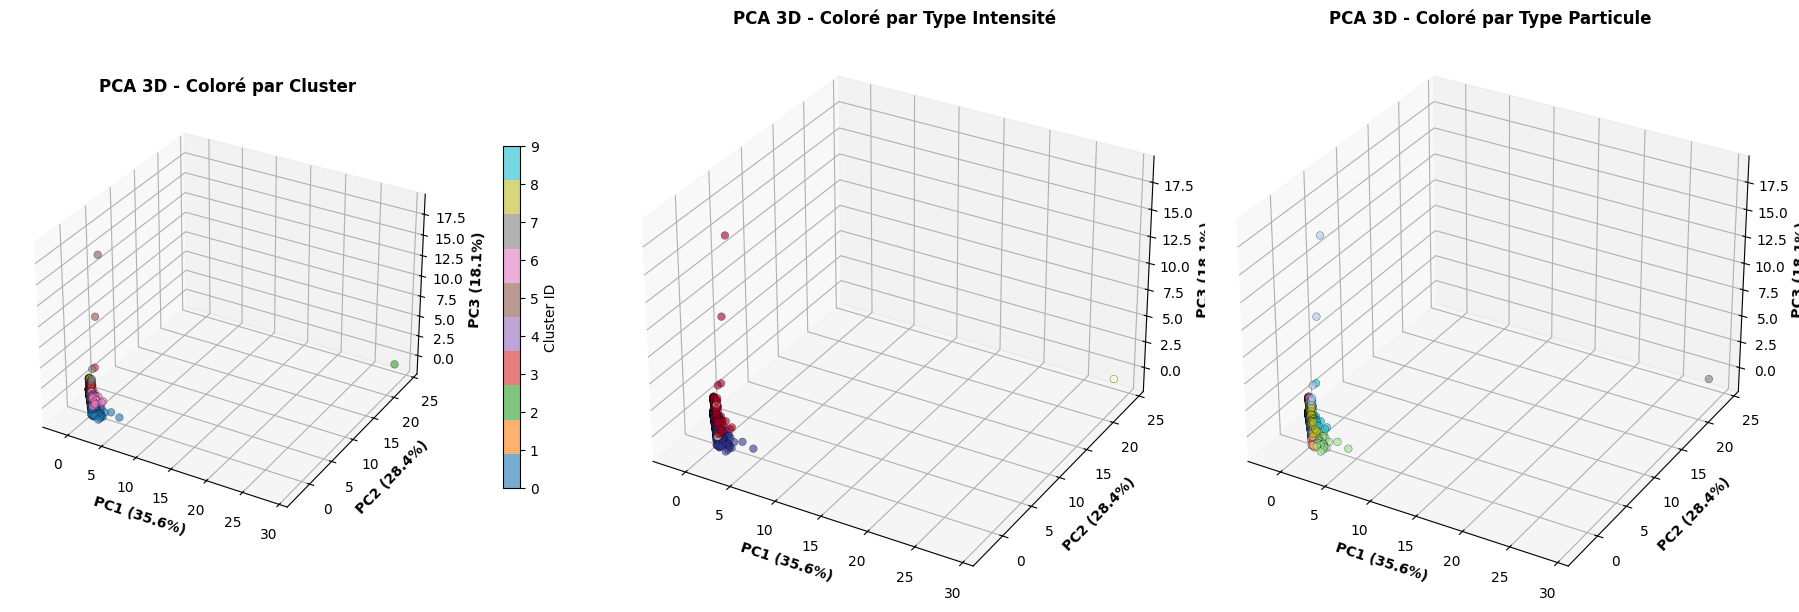


✓ Visualisation PCA 3D générée


In [123]:
# Visualisation 3D PCA
fig = plt.figure(figsize=(18, 6))

# Vue 1: PCA coloré par Cluster_Combined
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(df_particles['PCA_1'], 
                       df_particles['PCA_2'],
                       df_particles['PCA_3'],
                       c=df_particles['Cluster_Combined'], 
                       cmap='tab10', s=30, alpha=0.6, edgecolors='black', linewidth=0.3)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10, fontweight='bold')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10, fontweight='bold')
ax1.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=10, fontweight='bold')
ax1.set_title('PCA 3D - Coloré par Cluster', fontsize=12, fontweight='bold')
plt.colorbar(scatter1, ax=ax1, label='Cluster ID', shrink=0.6, pad=0.1)

# Vue 2: PCA coloré par Type d'intensité
ax2 = fig.add_subplot(132, projection='3d')
type_colors = {'Type_1_Blanc': 0, 'Type_2_Gris': 1, 'Type_3_Noir': 2}
color_map = df_particles['Type'].map(type_colors)
scatter2 = ax2.scatter(df_particles['PCA_1'], 
                       df_particles['PCA_2'],
                       df_particles['PCA_3'],
                       c=color_map, 
                       cmap='RdYlBu_r', s=30, alpha=0.6, edgecolors='black', linewidth=0.3)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10, fontweight='bold')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10, fontweight='bold')
ax2.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=10, fontweight='bold')
ax2.set_title('PCA 3D - Coloré par Type Intensité', fontsize=12, fontweight='bold')

# Vue 3: PCA coloré par Particle_Type_Combined
ax3 = fig.add_subplot(133, projection='3d')
unique_ptypes = df_particles['Particle_Type_Combined'].unique()
ptype_to_num = {t: i for i, t in enumerate(unique_ptypes)}
color_map_ptype = df_particles['Particle_Type_Combined'].map(ptype_to_num)
scatter3 = ax3.scatter(df_particles['PCA_1'], 
                       df_particles['PCA_2'],
                       df_particles['PCA_3'],
                       c=color_map_ptype, 
                       cmap='tab20', s=30, alpha=0.6, edgecolors='black', linewidth=0.3)
ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10, fontweight='bold')
ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10, fontweight='bold')
ax3.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=10, fontweight='bold')
ax3.set_title('PCA 3D - Coloré par Type Particule', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Visualisation PCA 3D générée")

## 8️⃣ Identification de la Zone Équilibrée Représentative

In [124]:

zone_info_df = pd.DataFrame([zone_info])
zone_info_df.to_csv("zone_equilibree_info.csv", index=False)
print("\n✓ Informations de la zone équilibrée sauvegardées: zone_equilibree_info.csv")

# IMPORTANT: Créer la classification combinée AVANT les visualisations qui l'utilisent
print("\n🏷️ Création de la classification combinée Particle_Type_Combined...")

def classify_particle_combined(row):
    """Classification combinée: Intensity × Size × Shape"""
    intensity = row['Intensity_Score']
    size = row['Size_Score']
    shape = row['Shape_Score']
    
    # Seuils
    intensity_low, intensity_high = 85, 170
    size_threshold = 150
    shape_threshold = 0.7
    
    # Déterminer Intensité
    if intensity < intensity_low:
        intensity_label = "Noir"
    elif intensity < intensity_high:
        intensity_label = "Gris"
    else:
        intensity_label = "Blanc"
    
    # Déterminer Taille
    size_label = "Petit" if size < size_threshold else "Grand"
    
    # Déterminer Forme
    shape_label = "Rond" if shape > shape_threshold else "Anguleux"
    
    return f"{intensity_label}_{size_label}_{shape_label}"

df_particles['Particle_Type_Combined'] = df_particles.apply(classify_particle_combined, axis=1)
print(f"✓ Classification créée avec {df_particles['Particle_Type_Combined'].nunique()} types uniques")


✓ Informations de la zone équilibrée sauvegardées: zone_equilibree_info.csv

🏷️ Création de la classification combinée Particle_Type_Combined...
✓ Classification créée avec 12 types uniques


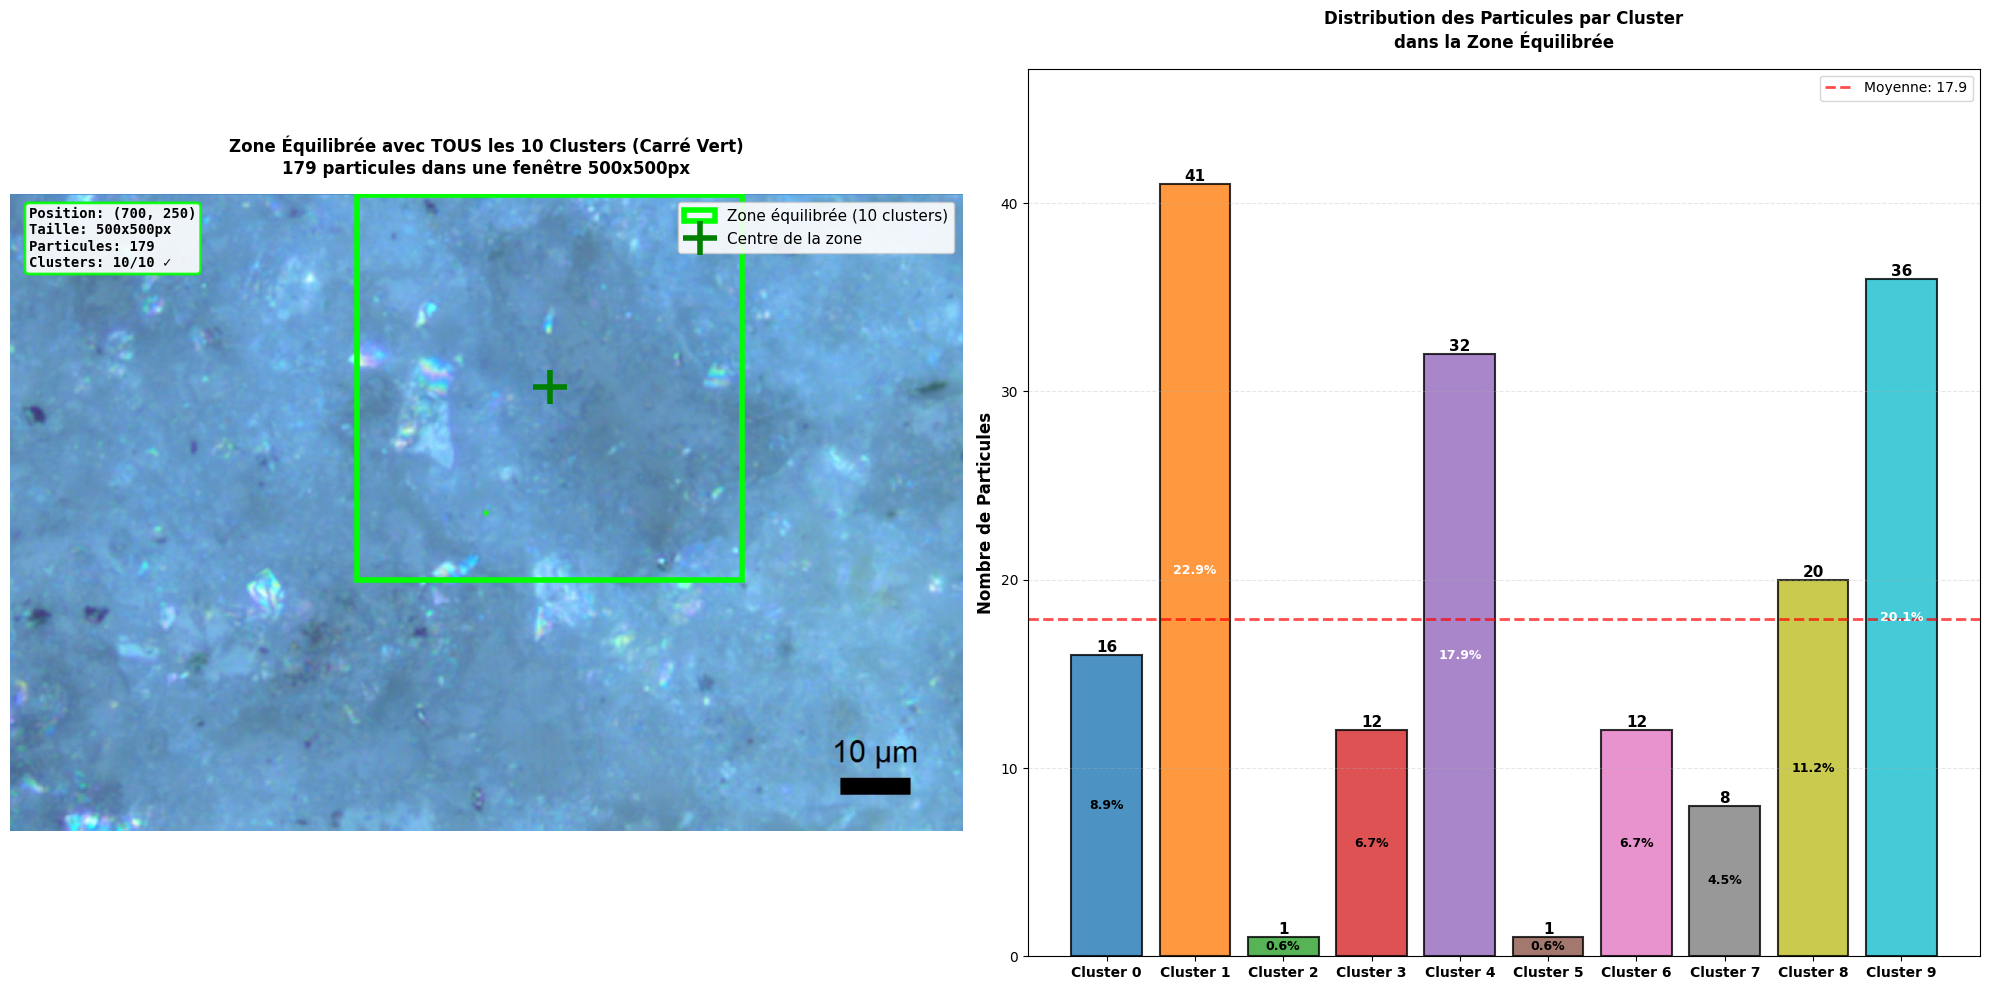


✓ Zone équilibrée visualisée avec distribution des clusters

📊 TABLEAU RÉCAPITULATIF - PARTICULES PAR CLUSTER DANS LA ZONE

Cluster    Quantité     % Zone       % Global     Écart     
--------------------------------------------------------------------------------
Cluster 0  16             8.94%       10.35%       -1.41%
Cluster 1  41            22.91%       26.88%       -3.98%
Cluster 2  1              0.56%        0.13%       +0.42%
Cluster 3  12             6.70%        5.78%       +0.92%
Cluster 4  32            17.88%       20.03%       -2.15%
Cluster 5  1              0.56%        0.27%       +0.29%
Cluster 6  12             6.70%        4.84%       +1.87%
Cluster 7  8              4.47%        1.61%       +2.86%
Cluster 8  20            11.17%        8.74%       +2.44%
Cluster 9  36            20.11%       21.37%       -1.26%
--------------------------------------------------------------------------------
TOTAL      179          100.00%     
✓ Informations du meilleur échantil

In [125]:
# Visualisation avec carré vert et distribution des clusters
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# GRAPHIQUE 1: Image avec carré vert
ax = axes[0]
ax.imshow(img_rgb)
ax.set_title(f'Zone Équilibrée avec TOUS les {total_clusters} Clusters (Carré Vert)\n' + 
            f'{best_window["n_particles"]} particules dans une fenêtre {square_size}x{square_size}px', 
            fontsize=12, fontweight='bold', pad=15)
ax.axis('off')

green_square = Rectangle((x_topleft, y_topleft), square_size, square_size, 
                         linewidth=4, edgecolor='lime', facecolor='none', 
                         label=f'Zone équilibrée ({total_clusters} clusters)')
ax.add_patch(green_square)

ax.plot(x_center, y_center, 'g+', markersize=25, markeredgewidth=4, 
       label='Centre de la zone')

text_info = f"Position: ({x_center:.0f}, {y_center:.0f})\n"
text_info += f"Taille: {square_size}x{square_size}px\n"
text_info += f"Particules: {best_window['n_particles']}\n"
text_info += f"Clusters: {total_clusters}/{total_clusters} ✓"

ax.text(0.02, 0.98, text_info, transform=ax.transAxes, 
       fontsize=10, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='lime', linewidth=2),
       fontweight='bold', family='monospace')

ax.legend(loc='upper right', fontsize=11, framealpha=0.9)

# GRAPHIQUE 2: Distribution des clusters
ax2 = axes[1]

cluster_ids = sorted(df_particles['Cluster_Combined'].unique())
cluster_counts_in_zone = [region_cluster_counts.get(cid, 0) for cid in cluster_ids]

colors_clusters = plt.cm.tab10(np.linspace(0, 1, len(cluster_ids)))
bars = ax2.bar(range(len(cluster_ids)), cluster_counts_in_zone, 
               color=colors_clusters, edgecolor='black', linewidth=1.5, alpha=0.8)

ax2.set_xticks(range(len(cluster_ids)))
ax2.set_xticklabels([f'Cluster {cid}' for cid in cluster_ids], fontsize=10, fontweight='bold')
ax2.set_ylabel('Nombre de Particules', fontsize=12, fontweight='bold')
ax2.set_title(f'Distribution des Particules par Cluster\ndans la Zone Équilibrée', 
             fontsize=12, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='y', linestyle='--')

for i, (count, bar) in enumerate(zip(cluster_counts_in_zone, bars)):
    pct = 100 * count / best_window['n_particles']
    height = bar.get_height()
    
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax2.text(bar.get_x() + bar.get_width()/2., height/2,
            f'{pct:.1f}%',
            ha='center', va='center', fontsize=9, fontweight='bold',
            color='white' if count > max(cluster_counts_in_zone)/2 else 'black')

mean_count = np.mean(cluster_counts_in_zone)
ax2.axhline(y=mean_count, color='red', linestyle='--', linewidth=2, 
           label=f'Moyenne: {mean_count:.1f}', alpha=0.7)
ax2.legend(loc='upper right', fontsize=10)
ax2.set_ylim(0, max(cluster_counts_in_zone) * 1.15)

plt.tight_layout()
plt.show()

print("\n✓ Zone équilibrée visualisée avec distribution des clusters")

# Afficher aussi un tableau récapitulatif dans la console
print("\n" + "="*80)
print("📊 TABLEAU RÉCAPITULATIF - PARTICULES PAR CLUSTER DANS LA ZONE")
print("="*80)
print(f"\n{'Cluster':<10} {'Quantité':<12} {'% Zone':<12} {'% Global':<12} {'Écart':<10}")
print("-" * 80)

for cluster_id in sorted(df_particles['Cluster_Combined'].unique()):
    count = region_cluster_counts.get(cluster_id, 0)
    pct_zone = 100 * count / best_window['n_particles']
    pct_global = 100 * global_cluster_counts[cluster_id] / len(df_particles)
    ecart = pct_zone - pct_global
    
    print(f"Cluster {cluster_id:<2} {count:<12} {pct_zone:>6.2f}%{'':<5} {pct_global:>6.2f}%{'':<5} {ecart:>+6.2f}%")

print("-" * 80)
print(f"{'TOTAL':<10} {best_window['n_particles']:<12} {'100.00%':<12}")
print("="*80)

# Sauvegarder les informations de l'échantillon (pour compatibilité)
best_sample_info = {
    'Center_X': x_center,
    'Center_Y': y_center,
    'Total_Clusters': total_clusters,
    'Total_Particles_In_Zone': best_window['n_particles'],
    'Window_Size_px': square_size,
    'TopLeft_X': x_topleft,
    'TopLeft_Y': y_topleft,
    'All_Clusters_Present': 'YES',
    'Score': best_score_overall if best_score_overall != -np.inf else 0.0
}

best_sample_df = pd.DataFrame([best_sample_info])
best_sample_df.to_csv("best_representative_sample.csv", index=False)
print("✓ Informations du meilleur échantillon sauvegardées: best_representative_sample.csv")

print("\n" + "="*80)
print("✅ IDENTIFICATION DE LA ZONE ÉQUILIBRÉE TERMINÉE!")
print("="*80)

## 9️⃣ Visualisations Avancées et Heatmaps


📊 Génération des scatter plots multi-niveaux...



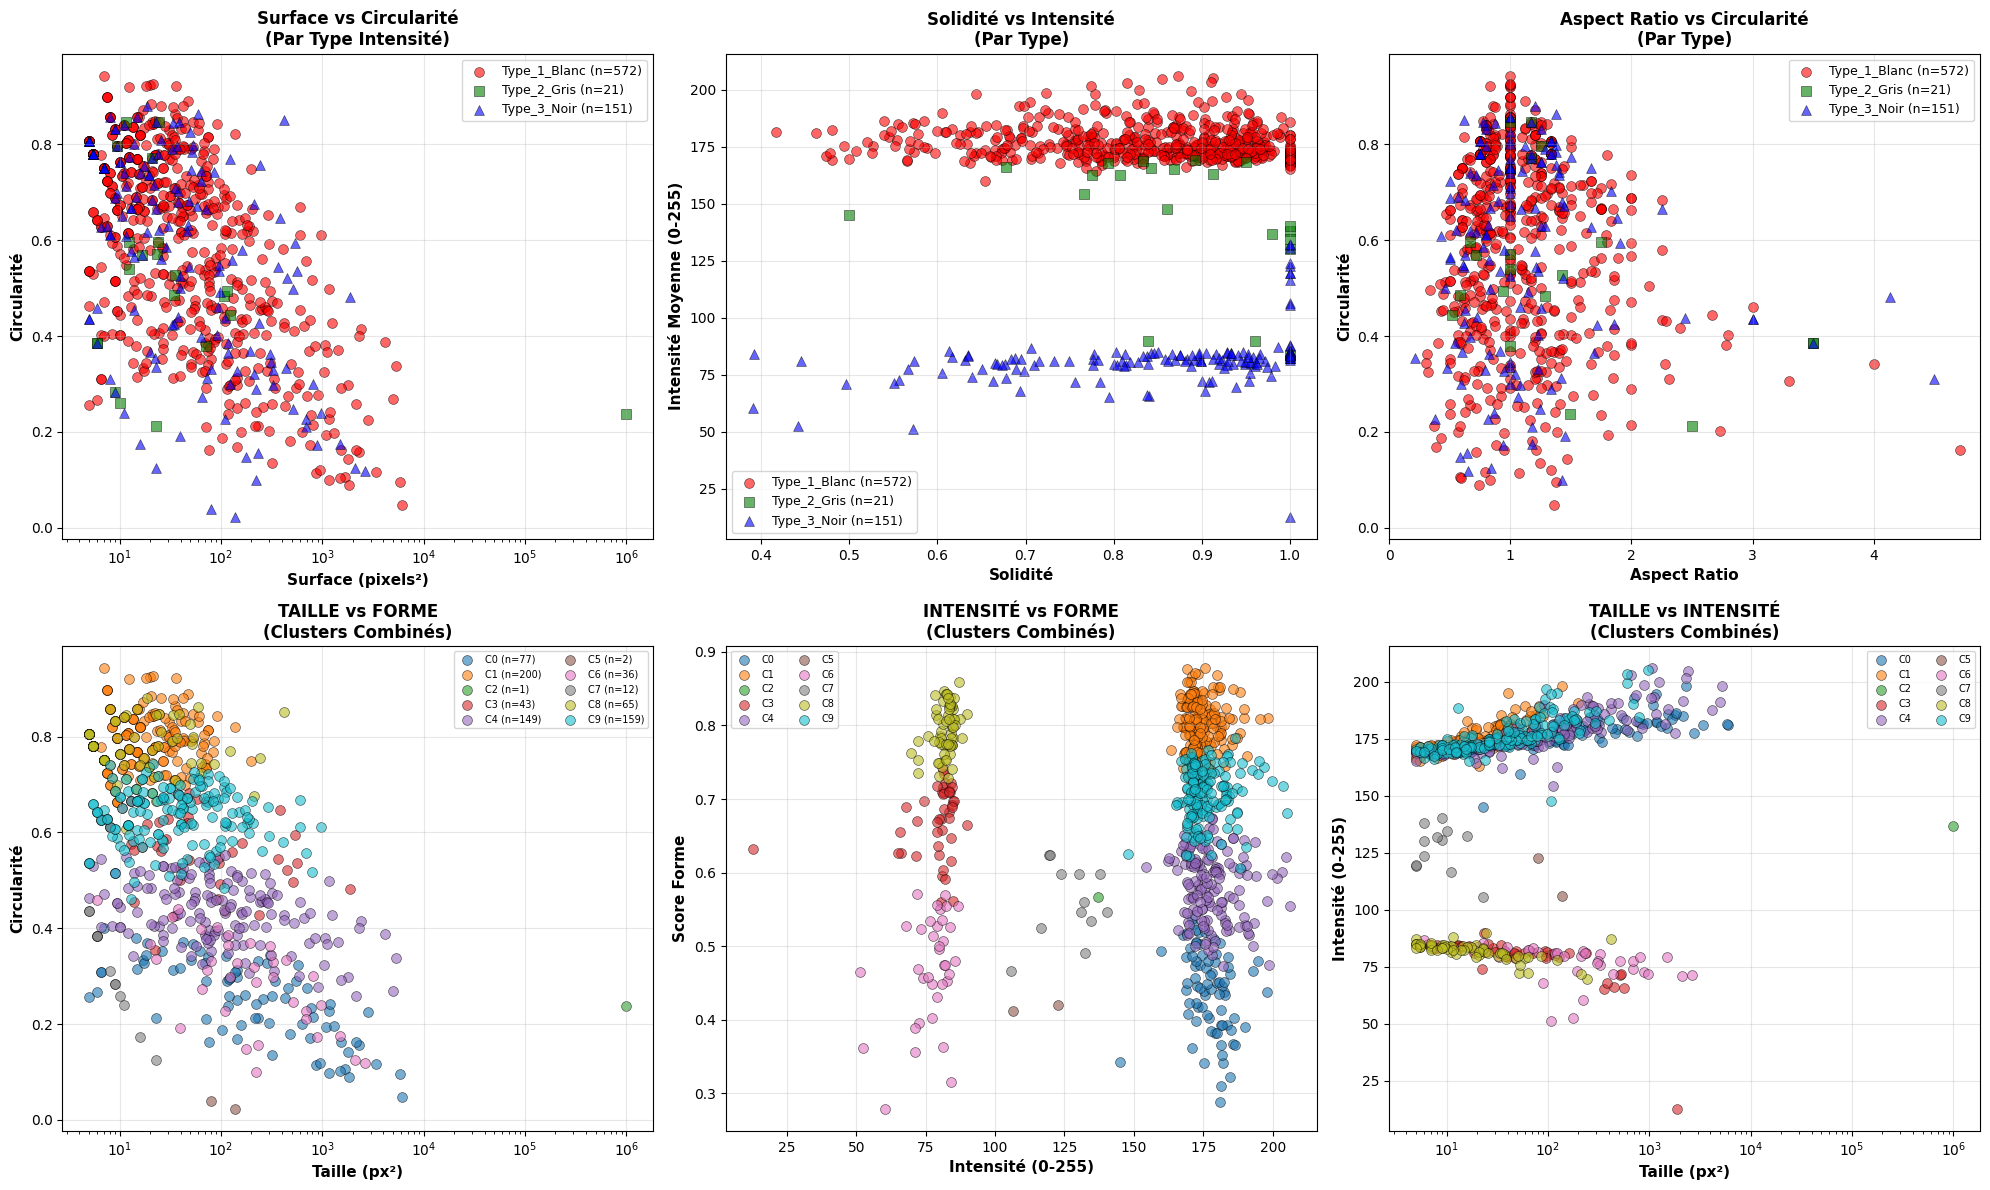

✓ Scatter plots générés


In [126]:
# Scatter plots multi-niveaux
print("\n📊 Génération des scatter plots multi-niveaux...\n")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Row 1: Vue par type d'intensité
ax = axes[0, 0]
for type_name, color, marker in [('Type_1_Blanc', 'red', 'o'), 
                                   ('Type_2_Gris', 'green', 's'), 
                                   ('Type_3_Noir', 'blue', '^')]:
    df_type = df_particles[df_particles['Type'] == type_name]
    if len(df_type) > 0:
        ax.scatter(df_type['Area_px2'], df_type['Circularity'], 
                  c=color, marker=marker, s=50, alpha=0.6, 
                  edgecolors='black', linewidth=0.5,
                  label=f'{type_name} (n={len(df_type)})')

ax.set_xlabel('Surface (pixels²)', fontsize=11, fontweight='bold')
ax.set_ylabel('Circularité', fontsize=11, fontweight='bold')
ax.set_title('Surface vs Circularité\n(Par Type Intensité)', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# Row 1, Col 2: Solidité vs Intensité
ax = axes[0, 1]
for type_name, color, marker in [('Type_1_Blanc', 'red', 'o'), 
                                   ('Type_2_Gris', 'green', 's'), 
                                   ('Type_3_Noir', 'blue', '^')]:
    df_type = df_particles[df_particles['Type'] == type_name]
    if len(df_type) > 0:
        ax.scatter(df_type['Solidity'], df_type['MeanIntensity'], 
                  c=color, marker=marker, s=50, alpha=0.6, 
                  edgecolors='black', linewidth=0.5,
                  label=f'{type_name} (n={len(df_type)})')

ax.set_xlabel('Solidité', fontsize=11, fontweight='bold')
ax.set_ylabel('Intensité Moyenne (0-255)', fontsize=11, fontweight='bold')
ax.set_title('Solidité vs Intensité\n(Par Type)', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# Row 1, Col 3: AspectRatio vs Circularité
ax = axes[0, 2]
for type_name, color, marker in [('Type_1_Blanc', 'red', 'o'), 
                                   ('Type_2_Gris', 'green', 's'), 
                                   ('Type_3_Noir', 'blue', '^')]:
    df_type = df_particles[df_particles['Type'] == type_name]
    if len(df_type) > 0:
        ax.scatter(df_type['AspectRatio'], df_type['Circularity'], 
                  c=color, marker=marker, s=50, alpha=0.6, 
                  edgecolors='black', linewidth=0.5,
                  label=f'{type_name} (n={len(df_type)})')

ax.set_xlabel('Aspect Ratio', fontsize=11, fontweight='bold')
ax.set_ylabel('Circularité', fontsize=11, fontweight='bold')
ax.set_title('Aspect Ratio vs Circularité\n(Par Type)', fontsize=12, fontweight='bold')
ax.set_xlim(0, min(5, df_particles['AspectRatio'].quantile(0.99)))
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# Row 2: Par clusters
if 'Cluster_Combined' in df_particles.columns:
    n_clusters = df_particles['Cluster_Combined'].nunique()
    colors_clusters = plt.get_cmap('tab10')(np.linspace(0, 1, n_clusters))
    
    # Taille vs Circularité
    ax = axes[1, 0]
    for cluster_id in sorted(df_particles['Cluster_Combined'].unique()):
        df_cluster = df_particles[df_particles['Cluster_Combined'] == cluster_id]
        ax.scatter(df_cluster['Size_Score'], df_cluster['Circularity'],
                  c=[colors_clusters[cluster_id]], s=50, alpha=0.6,
                  edgecolors='black', linewidth=0.5,
                  label=f'C{cluster_id} (n={len(df_cluster)})')
    
    ax.set_xlabel('Taille (px²)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Circularité', fontsize=11, fontweight='bold')
    ax.set_title('TAILLE vs FORME\n(Clusters Combinés)', fontsize=12, fontweight='bold')
    ax.set_xscale('log')
    ax.legend(loc='best', fontsize=7, ncol=2)
    ax.grid(True, alpha=0.3)
    
    # Intensité vs Shape
    ax = axes[1, 1]
    for cluster_id in sorted(df_particles['Cluster_Combined'].unique()):
        df_cluster = df_particles[df_particles['Cluster_Combined'] == cluster_id]
        ax.scatter(df_cluster['Intensity_Score'], df_cluster['Shape_Score'],
                  c=[colors_clusters[cluster_id]], s=50, alpha=0.6,
                  edgecolors='black', linewidth=0.5,
                  label=f'C{cluster_id}')
    
    ax.set_xlabel('Intensité (0-255)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Score Forme', fontsize=11, fontweight='bold')
    ax.set_title('INTENSITÉ vs FORME\n(Clusters Combinés)', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=7, ncol=2)
    ax.grid(True, alpha=0.3)
    
    # Taille vs Intensité
    ax = axes[1, 2]
    for cluster_id in sorted(df_particles['Cluster_Combined'].unique()):
        df_cluster = df_particles[df_particles['Cluster_Combined'] == cluster_id]
        ax.scatter(df_cluster['Size_Score'], df_cluster['Intensity_Score'],
                  c=[colors_clusters[cluster_id]], s=50, alpha=0.6,
                  edgecolors='black', linewidth=0.5,
                  label=f'C{cluster_id}')
    
    ax.set_xlabel('Taille (px²)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Intensité (0-255)', fontsize=11, fontweight='bold')
    ax.set_title('TAILLE vs INTENSITÉ\n(Clusters Combinés)', fontsize=12, fontweight='bold')
    ax.set_xscale('log')
    ax.legend(loc='best', fontsize=7, ncol=2)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Scatter plots générés")


🔥 Génération des heatmaps...



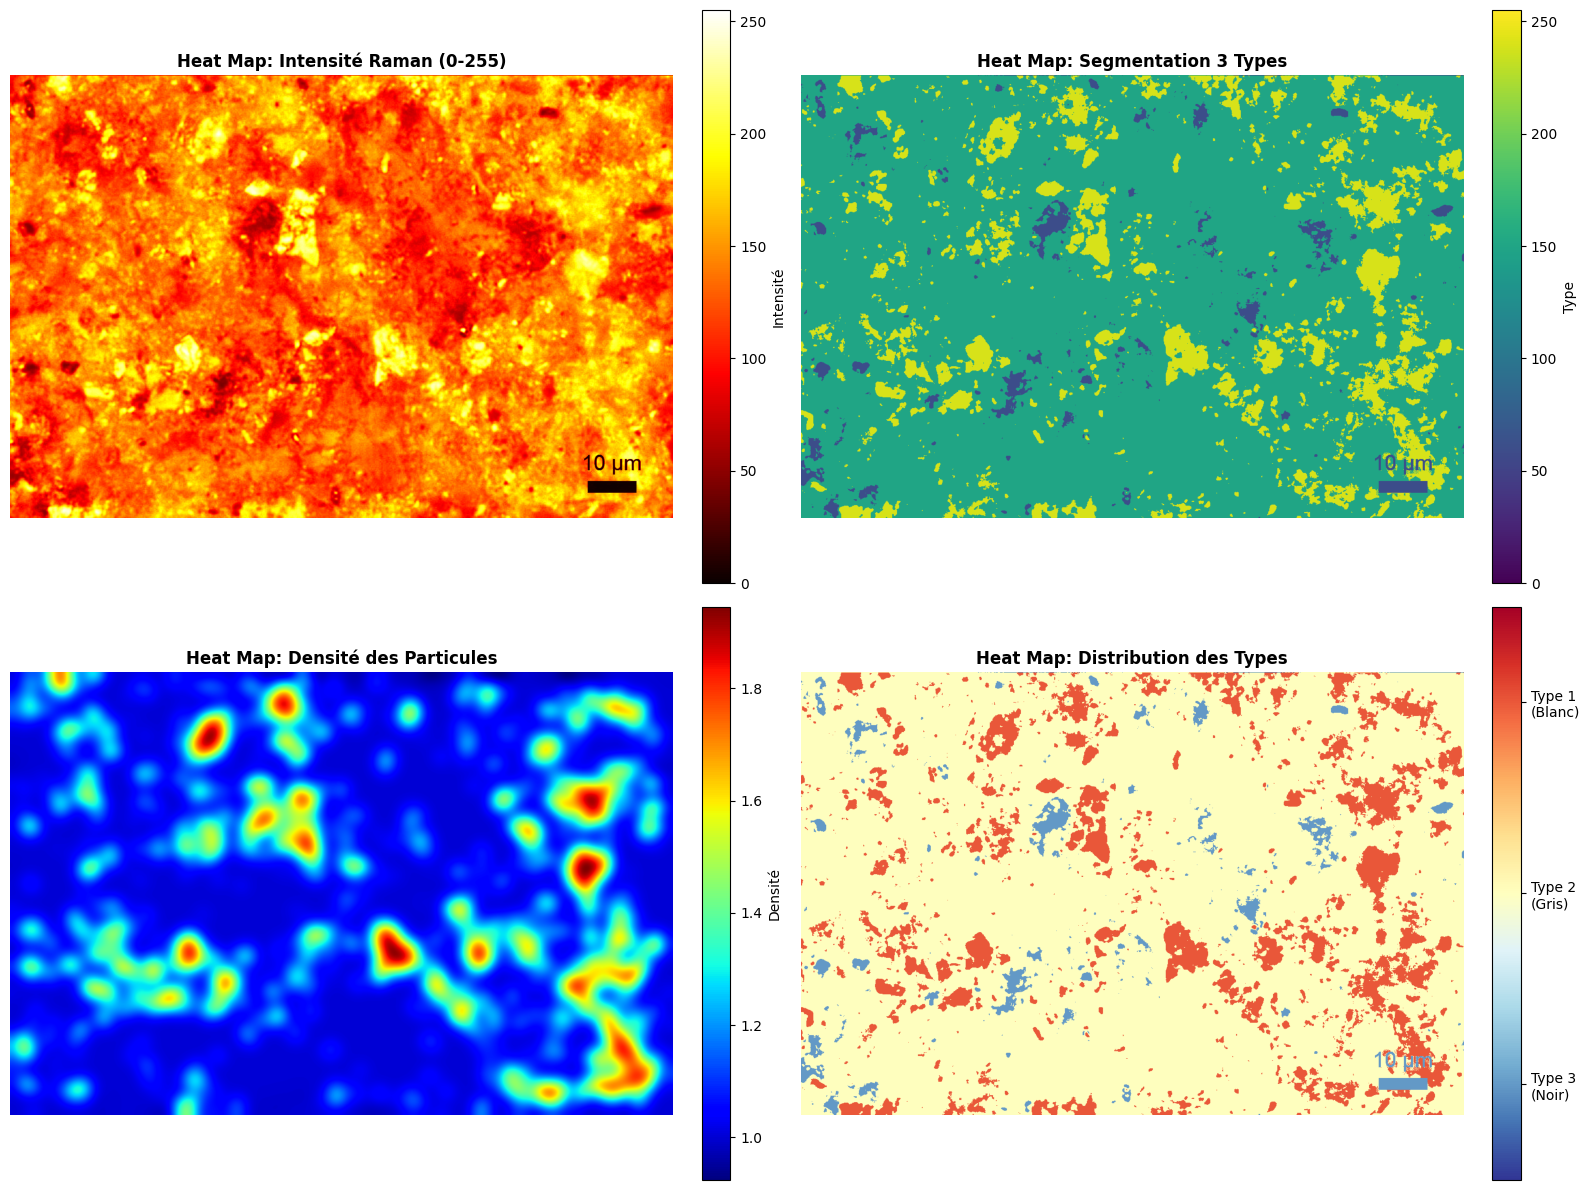

✓ Heat maps générées avec succès!


In [127]:
# Heat maps
print("\n🔥 Génération des heatmaps...\n")

# Vérifier que les masques existent
if not all(hasattr(var, '__len__') for var in [contours_type1, contours_type2, contours_type3]):
    raise ValueError("Les contours des types doivent être définis avant de générer les heatmaps")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Heatmap 1: Intensité Raman
ax = axes[0, 0]
im1 = ax.imshow(gray_eq, cmap='hot', vmin=0, vmax=255)
ax.set_title('Heat Map: Intensité Raman (0-255)', fontsize=12, fontweight='bold')
ax.axis('off')
plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04, label='Intensité')

# Heatmap 2: Segmentation
ax = axes[0, 1]
im2 = ax.imshow(segmentation_img, cmap='viridis', vmin=0, vmax=255)
ax.set_title('Heat Map: Segmentation 3 Types', fontsize=12, fontweight='bold')
ax.axis('off')
plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04, label='Type')

# Heatmap 3: Densité
ax = axes[1, 0]
density_map = np.zeros_like(gray_eq, dtype=np.float32)
for contours_list in [contours_type1, contours_type2, contours_type3]:
    for cnt in contours_list:
        mask_temp = np.zeros_like(gray_eq, dtype=np.uint8)
        cv2.drawContours(mask_temp, [cnt], -1, 1, -1)
        density_map += mask_temp

density_smooth = gaussian_filter(density_map, sigma=15)
im3 = ax.imshow(density_smooth, cmap='jet', interpolation='bilinear')
ax.set_title('Heat Map: Densité des Particules', fontsize=12, fontweight='bold')
ax.axis('off')
plt.colorbar(im3, ax=ax, fraction=0.046, pad=0.04, label='Densité')

# Heatmap 4: Distribution types
ax = axes[1, 1]
composite_map = np.zeros_like(gray_eq, dtype=np.float32)
composite_map[mask_type3] = 1.0
composite_map[mask_type2] = 2.0
composite_map[mask_type1] = 3.0

im4 = ax.imshow(composite_map, cmap='RdYlBu_r', vmin=0.5, vmax=3.5)
ax.set_title('Heat Map: Distribution des Types', fontsize=12, fontweight='bold')
ax.axis('off')
cbar4 = plt.colorbar(im4, ax=ax, fraction=0.046, pad=0.04, ticks=[1, 2, 3])
cbar4.ax.set_yticklabels(['Type 3\n(Noir)', 'Type 2\n(Gris)', 'Type 1\n(Blanc)'])

plt.tight_layout()
plt.show()

print("✓ Heat maps générées avec succès!")

## 9️⃣.1 Visualisation 3D des 3 Paramètres Combinés


📐 Génération de la visualisation 3D combinée...


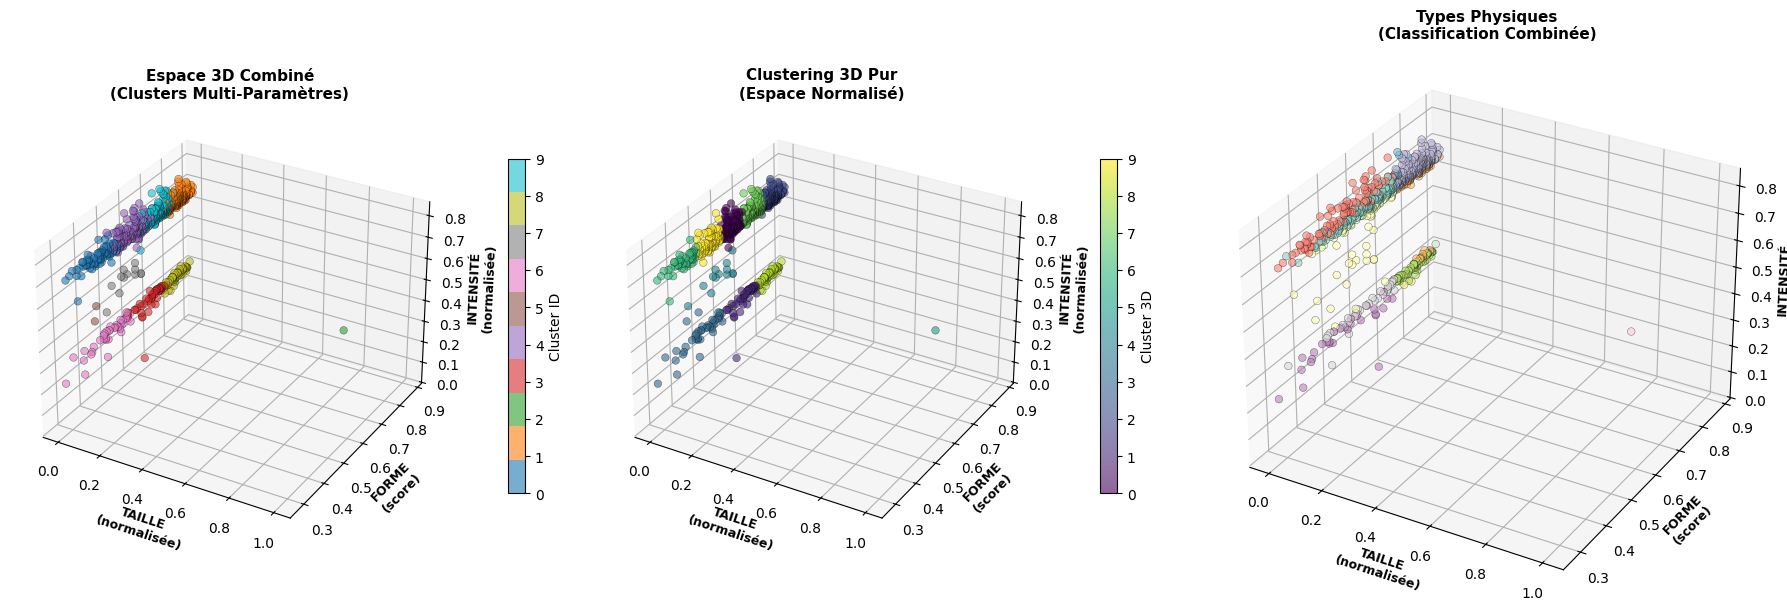

✓ Visualisation 3D combinée générée


In [128]:
print("\n📐 Génération de la visualisation 3D combinée...")

if 'Cluster_Combined' in df_particles.columns:
    fig = plt.figure(figsize=(18, 6))
    
    # Vue 1: Clusters combinés dans l'espace 3D
    ax1 = fig.add_subplot(131, projection='3d')
    scatter1 = ax1.scatter(df_particles['Size_Normalized'].values, 
                          df_particles['Shape_Normalized'].values,
                          df_particles['Intensity_Normalized'].values,
                          c=df_particles['Cluster_Combined'].values, 
                          cmap='tab10', s=30, alpha=0.6, edgecolors='black', linewidth=0.3)
    ax1.set_xlabel('TAILLE\n(normalisée)', fontsize=9, fontweight='bold')
    ax1.set_ylabel('FORME\n(score)', fontsize=9, fontweight='bold')
    ax1.set_zlabel('INTENSITÉ\n(normalisée)', fontsize=9, fontweight='bold')
    ax1.set_title('Espace 3D Combiné\n(Clusters Multi-Paramètres)', fontsize=11, fontweight='bold')
    plt.colorbar(scatter1, ax=ax1, label='Cluster ID', shrink=0.6, pad=0.1)
    
    # Vue 2: Clusters 3D purs
    if 'Cluster_3D' in df_particles.columns:
        ax2 = fig.add_subplot(132, projection='3d')
        scatter2 = ax2.scatter(df_particles['Size_Normalized'].values, 
                              df_particles['Shape_Normalized'].values,
                              df_particles['Intensity_Normalized'].values,
                              c=df_particles['Cluster_3D'].values, 
                              cmap='viridis', s=30, alpha=0.6, edgecolors='black', linewidth=0.3)
        ax2.set_xlabel('TAILLE\n(normalisée)', fontsize=9, fontweight='bold')
        ax2.set_ylabel('FORME\n(score)', fontsize=9, fontweight='bold')
        ax2.set_zlabel('INTENSITÉ\n(normalisée)', fontsize=9, fontweight='bold')
        ax2.set_title('Clustering 3D Pur\n(Espace Normalisé)', fontsize=11, fontweight='bold')
        plt.colorbar(scatter2, ax=ax2, label='Cluster 3D', shrink=0.6, pad=0.1)
    
    # Vue 3: Types de particules physiques
    if 'Particle_Type_Combined' in df_particles.columns:
        ax3 = fig.add_subplot(133, projection='3d')
        
        # Mapper les types à des couleurs
        unique_types = df_particles['Particle_Type_Combined'].unique()
        type_to_num = {t: i for i, t in enumerate(unique_types)}
        color_nums = df_particles['Particle_Type_Combined'].map(type_to_num)
        
        scatter3 = ax3.scatter(df_particles['Size_Normalized'].values, 
                              df_particles['Shape_Normalized'].values,
                              df_particles['Intensity_Normalized'].values,
                              c=color_nums.values, 
                              cmap='Set3', s=30, alpha=0.6, edgecolors='black', linewidth=0.3)
        ax3.set_xlabel('TAILLE\n(normalisée)', fontsize=9, fontweight='bold')
        ax3.set_ylabel('FORME\n(score)', fontsize=9, fontweight='bold')
        ax3.set_zlabel('INTENSITÉ\n(normalisée)', fontsize=9, fontweight='bold')
        ax3.set_title('Types Physiques\n(Classification Combinée)', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Visualisation 3D combinée générée")

## 9️⃣.2 Histogramme des Intensités avec Seuils


📊 Génération de l'histogramme des intensités...


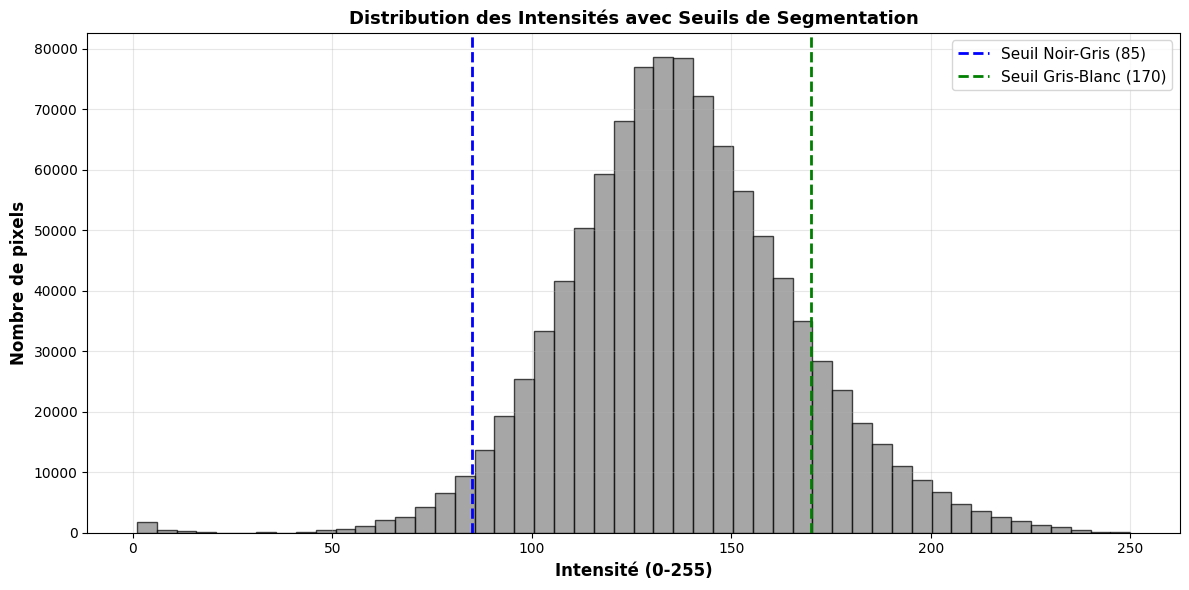

✓ Histogramme des intensités généré


In [129]:
print("\n📊 Génération de l'histogramme des intensités...")

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(gray_eq.ravel(), bins=50, color='gray', alpha=0.7, edgecolor='black')
ax.axvline(thresh1, color='blue', linestyle='--', linewidth=2, label=f'Seuil Noir-Gris ({thresh1})')
ax.axvline(thresh2, color='green', linestyle='--', linewidth=2, label=f'Seuil Gris-Blanc ({thresh2})')
ax.set_xlabel('Intensité (0-255)', fontweight='bold', fontsize=12)
ax.set_ylabel('Nombre de pixels', fontweight='bold', fontsize=12)
ax.set_title('Distribution des Intensités avec Seuils de Segmentation', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Histogramme des intensités généré")

## 🔟 Rapport Final et Sauvegarde des Résultats

In [130]:
print("\n" + "="*80)
print("📋 RAPPORT FINAL - CLUSTERING COMBINÉ (TAILLE × FORME × INTENSITÉ)")
print("="*80)

print(f"\n📊 DONNÉES GÉNÉRALES:")
print(f"  Total particules détectées: {len(df_particles)}")
print(f"  Dimensions image: {gray.shape}")
print(f"  Clusters identifiés: {n_main_clusters}")
print(f"  Types de particules uniques: {df_particles['Particle_Type_Combined'].nunique()}")

print(f"\n🔬 SEGMENTATION INITIALE PAR INTENSITÉ:")
for type_name in ['Type_1_Blanc', 'Type_2_Gris', 'Type_3_Noir']:
    count = len(df_particles[df_particles['Type'] == type_name])
    pct = 100 * count / len(df_particles) if len(df_particles) > 0 else 0
    avg_size = df_particles[df_particles['Type'] == type_name]['Size_Score'].mean()
    print(f"  {type_name}: {count} particules ({pct:.1f}%) - Taille moy: {avg_size:.1f} px²")

print(f"\n🎯 CLUSTERING COMBINÉ MULTI-PARAMÈTRES:")
print(f"  Nombre de clusters: {n_main_clusters}")
print(f"  Méthode: KMeans avec pondération (Taille + Forme + Intensité)")

print(f"\n📐 CLUSTERING 3D:")
print(f"  Nombre de clusters 3D: {n_3d_clusters}")

print(f"\n🏷️ CLASSIFICATION PHYSIQUE COMBINÉE:")
print(f"  Types uniques identifiés: {df_particles['Particle_Type_Combined'].nunique()}")
print(f"\n  Top 10 types:")
for idx, (ptype, count) in enumerate(df_particles['Particle_Type_Combined'].value_counts().head(10).items(), 1):
    pct = 100 * count / len(df_particles)
    print(f"    {idx:2d}. {ptype}: {count:3d} ({pct:5.1f}%)")

print(f"\n📈 STATISTIQUES DES 3 DIMENSIONS:")
print(f"  TAILLE (Surface):")
print(f"    Min: {df_particles['Size_Score'].min():.1f} px²")
print(f"    Max: {df_particles['Size_Score'].max():.1f} px²")
print(f"    Moyenne: {df_particles['Size_Score'].mean():.1f} px²")
print(f"    Médiane: {df_particles['Size_Score'].median():.1f} px²")

print(f"\n  FORME (Score composite):")
print(f"    Min: {df_particles['Shape_Score'].min():.3f}")
print(f"    Max: {df_particles['Shape_Score'].max():.3f}")
print(f"    Moyenne: {df_particles['Shape_Score'].mean():.3f}")

print(f"\n  INTENSITÉ:")
print(f"    Min: {df_particles['Intensity_Score'].min():.1f}/255")
print(f"    Max: {df_particles['Intensity_Score'].max():.1f}/255")
print(f"    Moyenne: {df_particles['Intensity_Score'].mean():.1f}/255")

print("\n" + "="*80)
print("✅ ANALYSE STATISTIQUE COMPLÈTE TERMINÉE!")
print("="*80)


📋 RAPPORT FINAL - CLUSTERING COMBINÉ (TAILLE × FORME × INTENSITÉ)

📊 DONNÉES GÉNÉRALES:
  Total particules détectées: 744
  Dimensions image: (826, 1236)
  Clusters identifiés: 10
  Types de particules uniques: 12

🔬 SEGMENTATION INITIALE PAR INTENSITÉ:
  Type_1_Blanc: 572 particules (76.9%) - Taille moy: 204.9 px²
  Type_2_Gris: 21 particules (2.8%) - Taille moy: 47576.7 px²
  Type_3_Noir: 151 particules (20.3%) - Taille moy: 158.0 px²

🎯 CLUSTERING COMBINÉ MULTI-PARAMÈTRES:
  Nombre de clusters: 10
  Méthode: KMeans avec pondération (Taille + Forme + Intensité)

📐 CLUSTERING 3D:
  Nombre de clusters 3D: 10

🏷️ CLASSIFICATION PHYSIQUE COMBINÉE:
  Types uniques identifiés: 12

  Top 10 types:
     1. Blanc_Petit_Rond: 236 ( 31.7%)
     2. Blanc_Petit_Anguleux: 148 ( 19.9%)
     3. Blanc_Grand_Anguleux:  98 ( 13.2%)
     4. Noir_Petit_Rond:  68 (  9.1%)
     5. Gris_Petit_Anguleux:  63 (  8.5%)
     6. Gris_Petit_Rond:  53 (  7.1%)
     7. Noir_Petit_Anguleux:  33 (  4.4%)
     8. Noir

In [131]:
# Sauvegarder tous les résultats
print("\n💾 SAUVEGARDE DES RÉSULTATS...")
print("="*80)

# 1. Données principales
df_particles.to_csv("particles_by_intensity_types.csv", index=False)
print("✓ particles_by_intensity_types.csv")

# 2. Résumés clustering
if 'Cluster_Combined' in df_particles.columns:
    cluster_combined_summary = df_particles.groupby('Cluster_Combined').agg({
        'Size_Score': ['count', 'mean', 'std'],
        'Shape_Score': ['mean', 'std'],
        'Intensity_Score': ['mean', 'std']
    }).round(3)
    cluster_combined_summary.to_csv("cluster_combined_summary.csv")
    print("✓ cluster_combined_summary.csv")

if 'Cluster_3D' in df_particles.columns:
    cluster_3d_summary = df_particles.groupby('Cluster_3D').agg({
        'Size_Normalized': ['count', 'mean', 'std'],
        'Shape_Normalized': ['mean', 'std'],
        'Intensity_Normalized': ['mean', 'std']
    }).round(4)
    cluster_3d_summary.to_csv("cluster_3d_summary.csv")
    print("✓ cluster_3d_summary.csv")

# 3. Distributions
particle_type_distribution = df_particles['Particle_Type_Combined'].value_counts()
particle_type_distribution.to_csv("particle_types_combined_distribution.csv", header=['Count'])
print("✓ particle_types_combined_distribution.csv")

# 4. Matrices de confusion
if 'Particle_Type_Combined' in df_particles.columns:
    confusion_matrix = pd.crosstab(
        df_particles['Type'], 
        df_particles['Particle_Type_Combined'],
        margins=True,
        margins_name='TOTAL'
    )
    confusion_matrix.to_csv("confusion_matrix_types.csv")
    print("✓ confusion_matrix_types.csv")

# 5. Tableaux croisés
if 'Cluster_Combined' in df_particles.columns:
    crosstab_intensity = pd.crosstab(
        df_particles['Cluster_Combined'],
        df_particles['Type']
    )
    crosstab_intensity.to_csv("crosstab_clusters_vs_intensity.csv")
    print("✓ crosstab_clusters_vs_intensity.csv")

# 6. Résultats PCA
pca_results = pd.DataFrame({
    'PCA_1': df_particles['PCA_1'],
    'PCA_2': df_particles['PCA_2'],
    'PCA_3': df_particles['PCA_3'],
    'Cluster_Combined': df_particles['Cluster_Combined'],
    'Type': df_particles['Type']
})
pca_results.to_csv("pca_3d_results.csv", index=False)
print("✓ pca_3d_results.csv")

# 7. Zone équilibrée
zone_info = {
    'Center_X': x_center,
    'Center_Y': y_center,
    'TopLeft_X': x_topleft,
    'TopLeft_Y': y_topleft,
    'Window_Size': square_size,
    'Total_Particles': best_window['n_particles'],
    'Total_Clusters': total_clusters
}

for cluster_id in sorted(df_particles['Cluster_Combined'].unique()):
    count = region_cluster_counts.get(cluster_id, 0)
    zone_info[f'Cluster_{cluster_id}_Count'] = count

zone_info_df = pd.DataFrame([zone_info])
zone_info_df.to_csv("zone_equilibree_info.csv", index=False)
print("✓ zone_equilibree_info.csv")

# 8. Meilleur échantillon
best_sample_info = {
    'Center_X': x_center,
    'Center_Y': y_center,
    'Total_Clusters': total_clusters,
    'Total_Particles_In_Zone': best_window['n_particles'],
    'Window_Size_px': square_size,
    'All_Clusters_Present': 'YES'
}
best_sample_df = pd.DataFrame([best_sample_info])
best_sample_df.to_csv("best_representative_sample.csv", index=False)
print("✓ best_representative_sample.csv")

print("\n" + "="*80)
print("✅ TOUS LES FICHIERS SAUVEGARDÉS!")
print("="*80)


💾 SAUVEGARDE DES RÉSULTATS...
✓ particles_by_intensity_types.csv
✓ cluster_combined_summary.csv
✓ cluster_3d_summary.csv
✓ particle_types_combined_distribution.csv
✓ confusion_matrix_types.csv
✓ crosstab_clusters_vs_intensity.csv
✓ pca_3d_results.csv
✓ zone_equilibree_info.csv
✓ best_representative_sample.csv

✅ TOUS LES FICHIERS SAUVEGARDÉS!
